# Preprocessing

## Initial setup

### Packages

In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import re

import warnings
warnings.filterwarnings('ignore')

### Dataset reading

In [350]:
original_df = pd.read_csv('../data/dataset.csv')
print(f"Dataset loaded: {original_df.shape[0]} rows × {original_df.shape[1]} columns")
print(original_df.columns)
print(original_df.shape)
original_df.head()


Dataset loaded: 21742 rows × 58 columns
Index(['Unnamed: 0', 'id', 'title', 'subtitle', 'sq_mt_built', 'sq_mt_useful',
       'n_rooms', 'n_bathrooms', 'n_floors', 'sq_mt_allotment', 'latitude',
       'longitude', 'raw_address', 'is_exact_address_hidden', 'street_name',
       'street_number', 'portal', 'floor', 'is_floor_under', 'door',
       'neighborhood_id', 'operation', 'rent_price', 'rent_price_by_area',
       'is_rent_price_known', 'buy_price', 'buy_price_by_area',
       'is_buy_price_known', 'house_type_id', 'is_renewal_needed',
       'is_new_development', 'built_year', 'has_central_heating',
       'has_individual_heating', 'are_pets_allowed', 'has_ac',
       'has_fitted_wardrobes', 'has_lift', 'is_exterior', 'has_garden',
       'has_pool', 'has_terrace', 'has_balcony', 'has_storage_room',
       'is_furnished', 'is_kitchen_equipped', 'is_accessible',
       'has_green_zones', 'energy_certificate', 'has_parking',
       'has_private_parking', 'has_public_parking',
     

,Unnamed: 0,id,title,subtitle,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,...,energy_certificate,has_parking,has_private_parking,has_public_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east
0,0,21742,"Piso en venta en calle de Godella, 64","San Cristóbal, Madrid",64.0,60.0,2,1.0,NaN,NaN,...,D,0,NaN,NaN,NaN,NaN,0,1,0,0
1,1,21741,Piso en venta en calle de la del Manojo de Rosas,"Los Ángeles, Madrid",70.0,NaN,3,1.0,NaN,NaN,...,en trámite,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,21740,"Piso en venta en calle del Talco, 68","San Andrés, Madrid",94.0,54.0,2,2.0,NaN,NaN,...,no indicado,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,21739,Piso en venta en calle Pedro Jiménez,"San Andrés, Madrid",64.0,NaN,2,1.0,NaN,NaN,...,en trámite,0,NaN,NaN,NaN,NaN,0,0,1,0
4,4,21738,Piso en venta en carretera de Villaverde a Val...,"Los Rosales, Madrid",108.0,90.0,2,2.0,NaN,NaN,...,en trámite,1,NaN,NaN,1,0.0,1,1,1,1


We just keep the columns we will be processing

In [351]:
columns = ['street_name',
           'floor',
           'house_type_id',
           'sq_mt_built', 'sq_mt_useful', 'n_rooms',
           'built_year', 'is_exterior', 'has_terrace', 'has_balcony', 'neighborhood_id', 'is_renewal_needed', 'has_garden', 'energy_certificate', 'is_new_development', 'n_bathrooms', 'has_lift','buy_price_by_area',
        ]
AMMENITIES_COLUMNS = ['has_ac', 'has_pool']
HEATING_COLUMNS = ['has_central_heating', 'has_individual_heating']
PARKING_COLUMNS = ['has_parking', 'has_private_parking', 'has_public_parking', 'is_parking_included_in_price']
ORIENTATION_COLUMNS = ['is_orientation_north', 'is_orientation_east', 'is_orientation_south', 'is_orientation_west']
RESPONSE_COLUMN = ['buy_price']

columns += AMMENITIES_COLUMNS
columns += HEATING_COLUMNS
columns += PARKING_COLUMNS
columns += ORIENTATION_COLUMNS
columns += RESPONSE_COLUMN

df = original_df[columns]

### NaN analysis

We display the information of NaN (null) for by columns

In [352]:
nulls = df.isnull().mean() * 100
print("NaN percentage by column:")
display(nulls.sort_values(ascending=False))

NaN percentage by column:


has_public_parking              100.000000
has_private_parking             100.000000
has_garden                       92.843345
has_balcony                      84.725416
has_pool                         76.216539
is_parking_included_in_price     64.497286
sq_mt_useful                     62.156195
has_terrace                      56.084997
built_year                       54.006071
has_ac                           48.436206
is_orientation_north             47.760096
is_orientation_east              47.760096
is_orientation_south             47.760096
is_orientation_west              47.760096
has_central_heating              37.411462
has_individual_heating           37.411462
street_name                      27.159415
is_exterior                      13.995953
floor                            11.990617
has_lift                         10.974151
is_new_development                4.562598
house_type_id                     1.798363
sq_mt_built                       0.579524
n_bathrooms

### Distinct values analysis

Distinct values in street_name:
street_name
NaN                                     5905
Paseo de la Castellana                   116
Calle de Bravo Murillo                    69
Calle del Príncipe de Vergara             60
Calle de Embajadores                      58
                                        ... 
Calle Peonias                              1
Calle de Hermenegildo Bielsa               1
Avenida de los arces                       1
Calle del Estrecho de Mesina, Madrid       1
Calle Burriana                             1
Name: count, Length: 6163, dtype: int64
---------
Distinct values in floor:
floor
1                       4440
2                       3546
3                       3001
NaN                     2607
4                       2323
Bajo                    2144
5                       1310
6                        913
7                        556
8                        326
Entreplanta exterior     236
9                        181
Semi-sótano exterior      55
Se

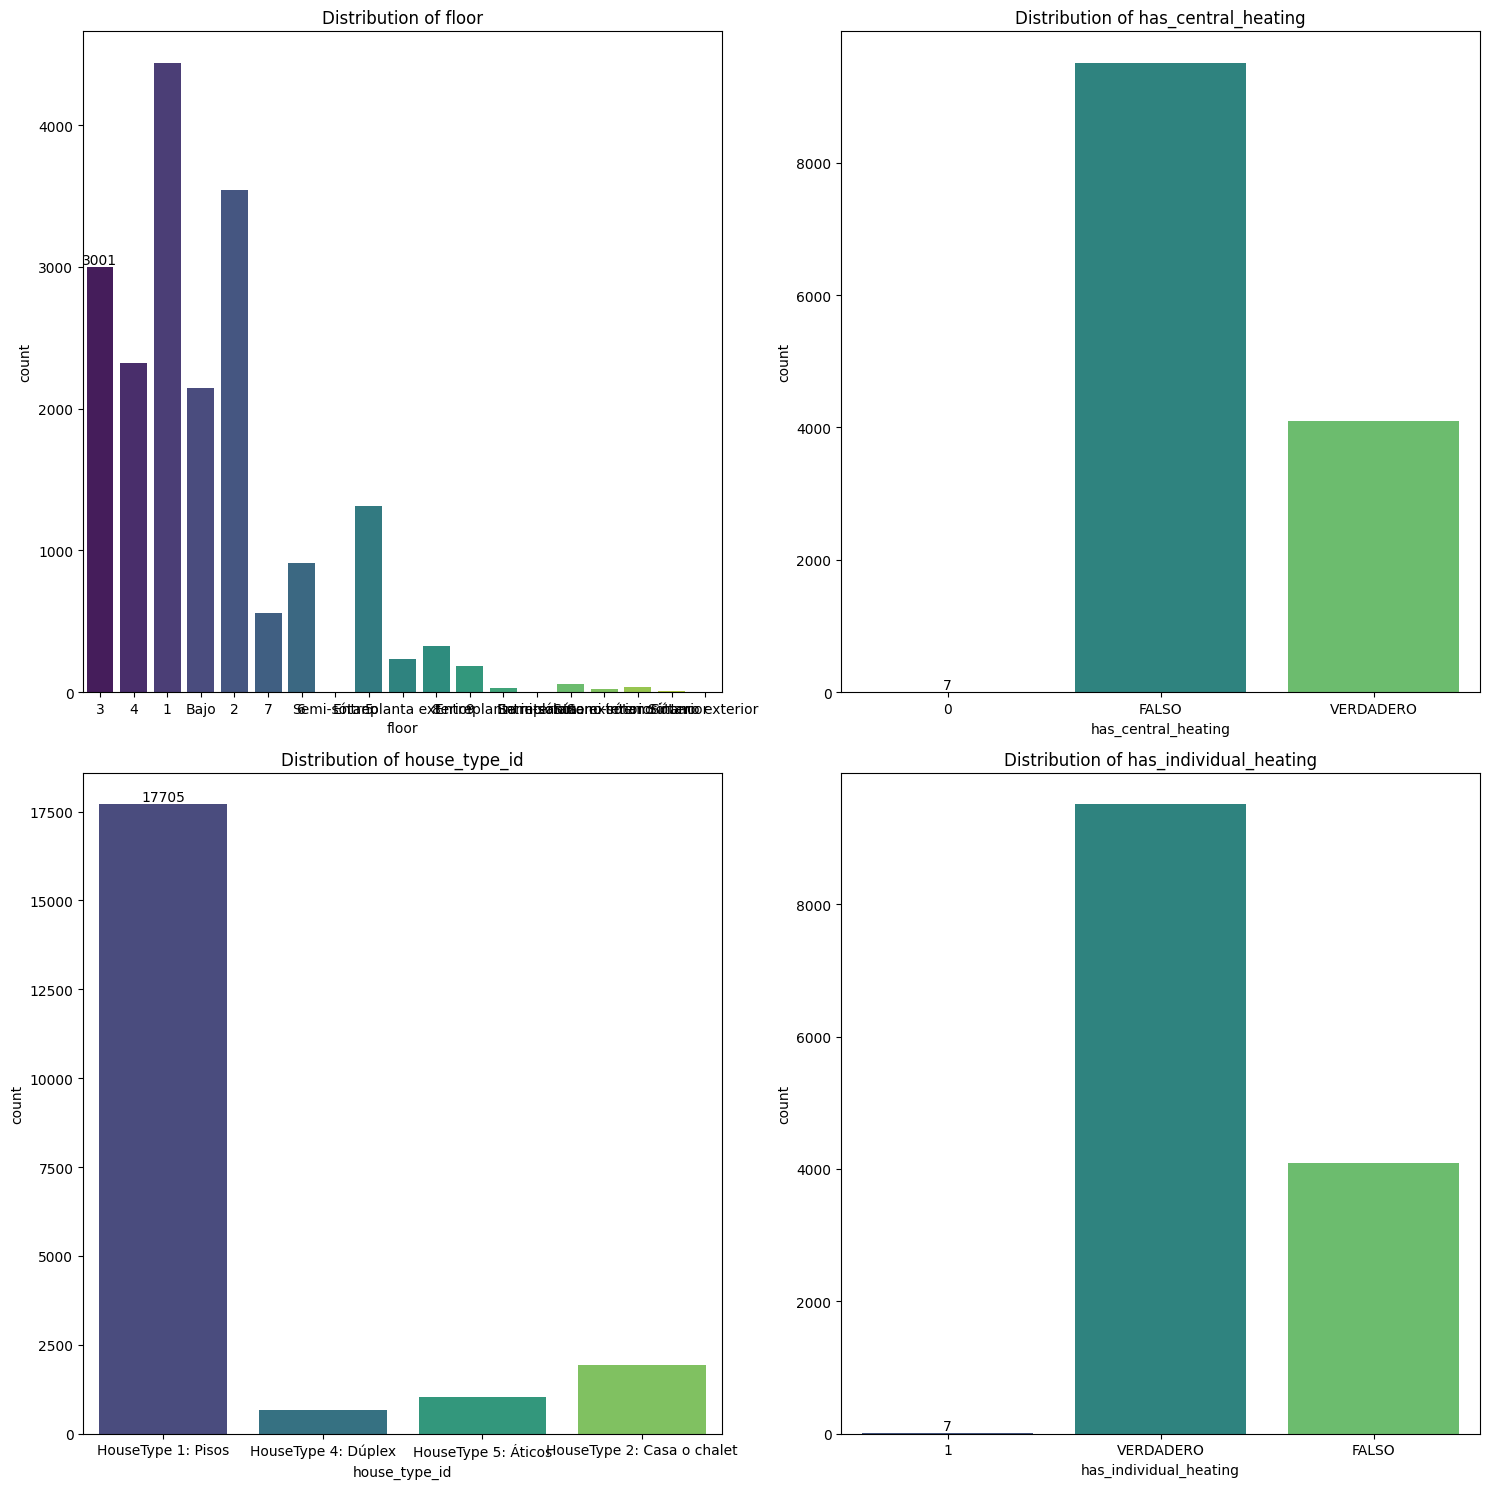

In [353]:
print("Distinct values in street_name:")
print(df['street_name'].value_counts(dropna=False))
print('---------')

print("Distinct values in floor:")
print(df['floor'].value_counts(dropna=False))
print('---------')

print("Distinct values in house_type_id:")
print(df['house_type_id'].value_counts(dropna=False))
print('---------')

print("Distinct values in has_central_heating:")
print(df['has_central_heating'].value_counts(dropna=False))
print('---------')

print("Distinct values in has_individual_heating:")
print(df['has_individual_heating'].value_counts(dropna=False))
print('---------')

fig, axes = plt.subplots(2, 2, figsize=(15, 15))


sns.countplot(x='floor', data=df, ax=axes[0][0], palette='viridis')
axes[0][0].set_title('Distribution of floor')
axes[0][0].set_xlabel('floor')
axes[0][0].bar_label(axes[0][0].containers[0])

sns.countplot(x='house_type_id', data=df, ax=axes[1][0], palette='viridis')
axes[1][0].set_title('Distribution of house_type_id')
axes[1][0].set_xlabel('house_type_id')
axes[1][0].bar_label(axes[1][0].containers[0])

sns.countplot(x='has_central_heating', data=df, ax=axes[0][1], palette='viridis')
axes[0][1].set_title('Distribution of has_central_heating')
axes[0][1].set_xlabel('has_central_heating')
axes[0][1].bar_label(axes[0][1].containers[0])

sns.countplot(x='has_individual_heating', data=df, ax=axes[1][1], palette='viridis')
axes[1][1].set_title('Distribution of has_individual_heating')
axes[1][1].set_xlabel('has_individual_heating')
axes[1][1].bar_label(axes[1][1].containers[0])

plt.tight_layout()
plt.show()

Distinct values in sq_mt_built:
sq_mt_built
70.0     494
60.0     484
80.0     427
65.0     377
90.0     357
        ... 
803.0      1
486.0      1
634.0      1
502.0      1
427.0      1
Name: count, Length: 679, dtype: int64
---------
Distinct values in sq_mt_useful:
sq_mt_useful
NaN      13514
70.0       277
60.0       232
80.0       219
50.0       203
         ...  
778.0        1
16.0         1
531.0        1
354.0        1
351.0        1
Name: count, Length: 409, dtype: int64
---------
Distinct values in n_rooms:
n_rooms
3     7214
2     5499
4     3367
1     2267
5     1757
6      715
0      439
7      259
8      112
9       54
10      26
11      10
12       9
13       6
24       3
15       2
16       1
18       1
14       1
Name: count, dtype: int64
---------
Distinct values in has_lift:
has_lift
VERDADERO    14885
FALSO         4448
NaN           2386
0               13
1               10
Name: count, dtype: int64
---------


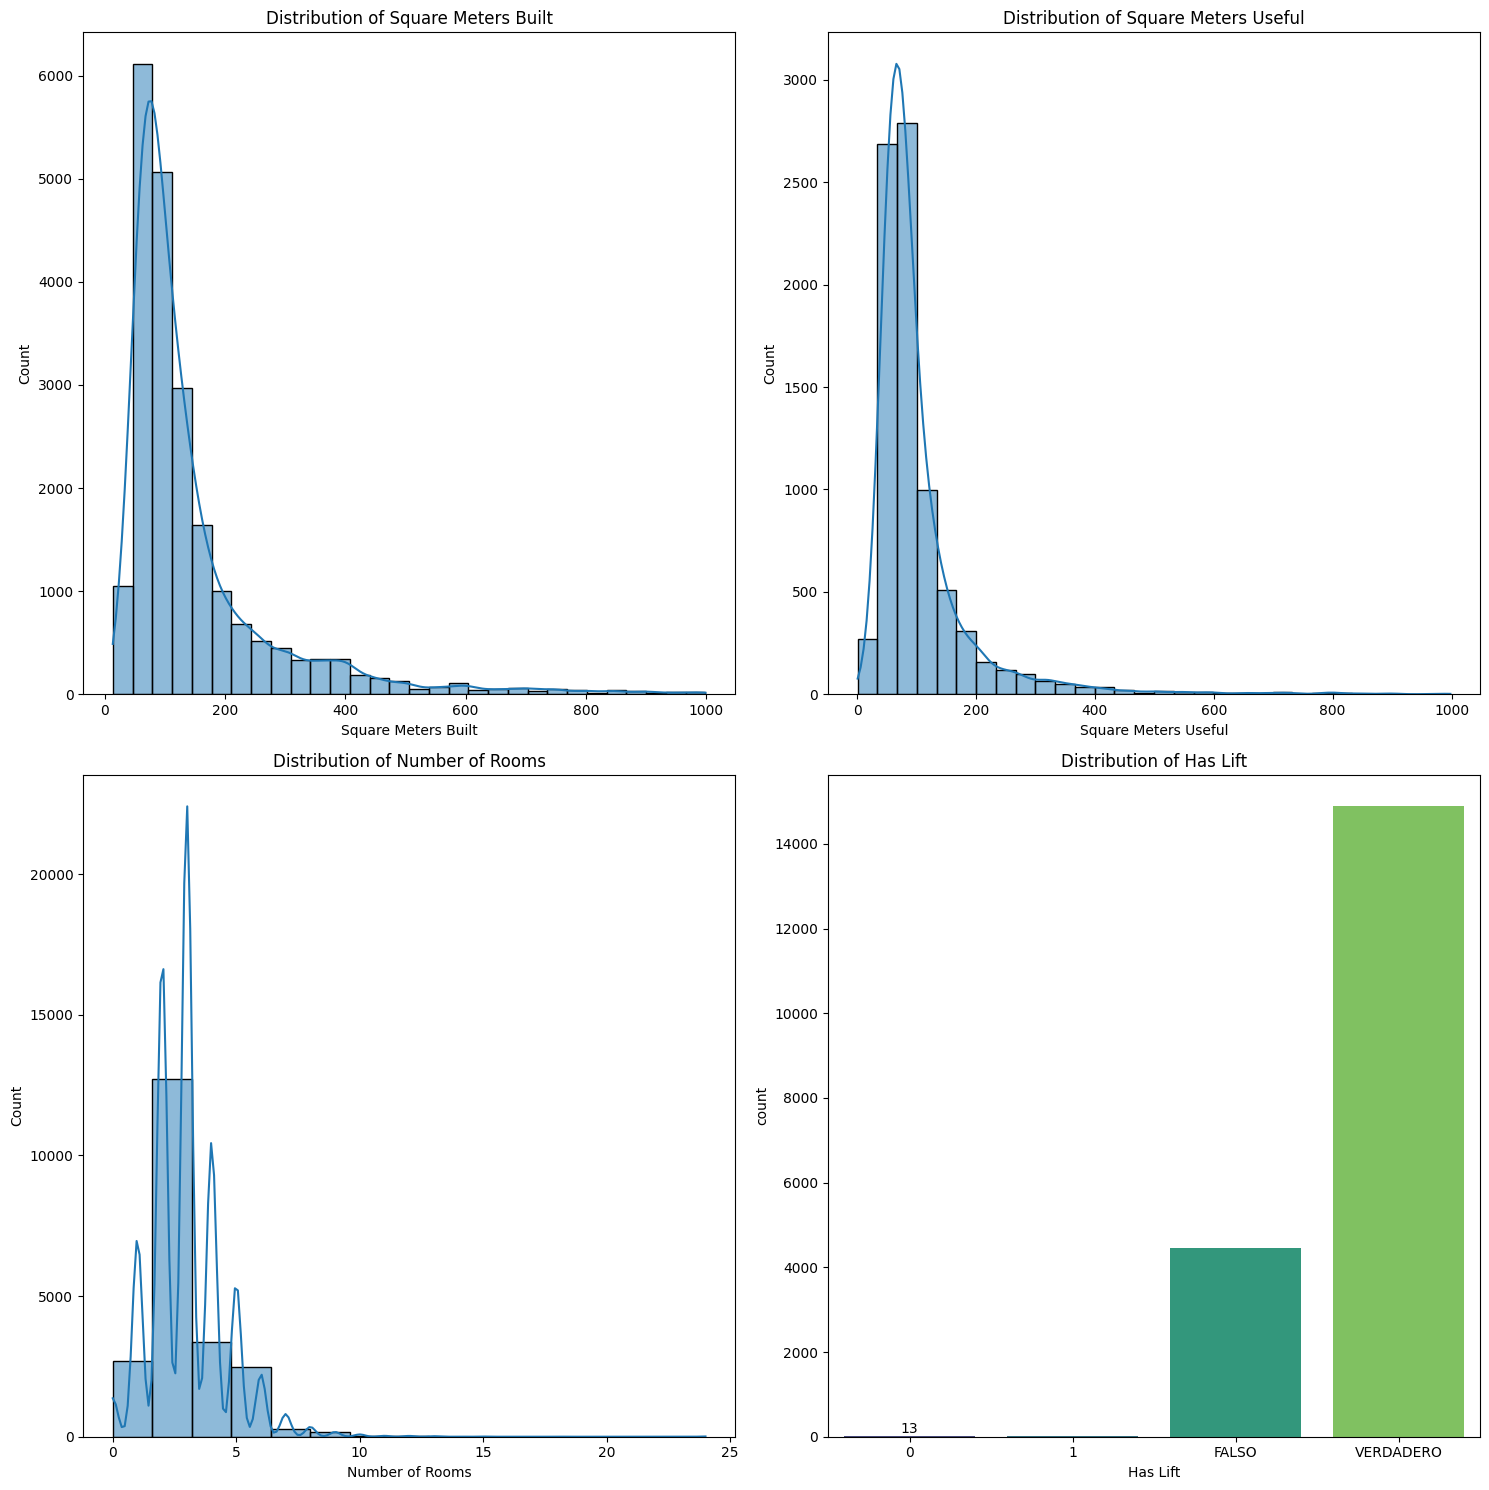

In [354]:
print("Distinct values in sq_mt_built:")
print(df['sq_mt_built'].value_counts(dropna=False))
print('---------')

print("Distinct values in sq_mt_useful:")
print(df['sq_mt_useful'].value_counts(dropna=False))
print('---------')

print("Distinct values in n_rooms:")
print(df['n_rooms'].value_counts(dropna=False))
print('---------')

print("Distinct values in has_lift:")
print(df['has_lift'].value_counts(dropna=False))
print('---------')

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Histogram for sq_mt_built
sns.histplot(data=df, x='sq_mt_built', bins=30, ax=axes[0][0], kde=True)
axes[0][0].set_title('Distribution of Square Meters Built')
axes[0][0].set_xlabel('Square Meters Built')

# Histogram for sq_mt_useful
sns.histplot(data=df, x='sq_mt_useful', bins=30, ax=axes[0][1], kde=True)
axes[0][1].set_title('Distribution of Square Meters Useful')
axes[0][1].set_xlabel('Square Meters Useful')

# Histogram for n_rooms
sns.histplot(data=df, x='n_rooms', bins=15, ax=axes[1][0], kde=True)
axes[1][0].set_title('Distribution of Number of Rooms')
axes[1][0].set_xlabel('Number of Rooms')

# Countplot for has_lift
sns.countplot(x='has_lift', data=df, ax=axes[1][1], palette='viridis')
axes[1][1].set_title('Distribution of Has Lift')
axes[1][1].set_xlabel('Has Lift')
axes[1][1].bar_label(axes[1][1].containers[0])

plt.tight_layout()
plt.show()

Distinct values in has_parking:
has_parking
FALSO        14003
VERDADERO     7714
0               20
1                5
Name: count, dtype: int64
---------
Distinct values in has_private_parking:
has_private_parking
NaN    21742
Name: count, dtype: int64
---------
Distinct values in has_public_parking:
has_public_parking
NaN    21742
Name: count, dtype: int64
---------
Distinct values in is_parking_included_in_price:
is_parking_included_in_price
NaN          14023
VERDADERO     7110
FALSO          604
1                5
Name: count, dtype: int64
---------
Distinct values in has_ac:
has_ac
VERDADERO    11200
NaN          10531
1               11
Name: count, dtype: int64
---------
Distinct values in has_pool:
has_pool
NaN          16571
VERDADERO     5167
1                4
Name: count, dtype: int64
---------
Distinct values in is_orientation_north:
is_orientation_north
NaN          10384
FALSO         8559
VERDADERO     2790
0                8
1                1
Name: count, dtype: int

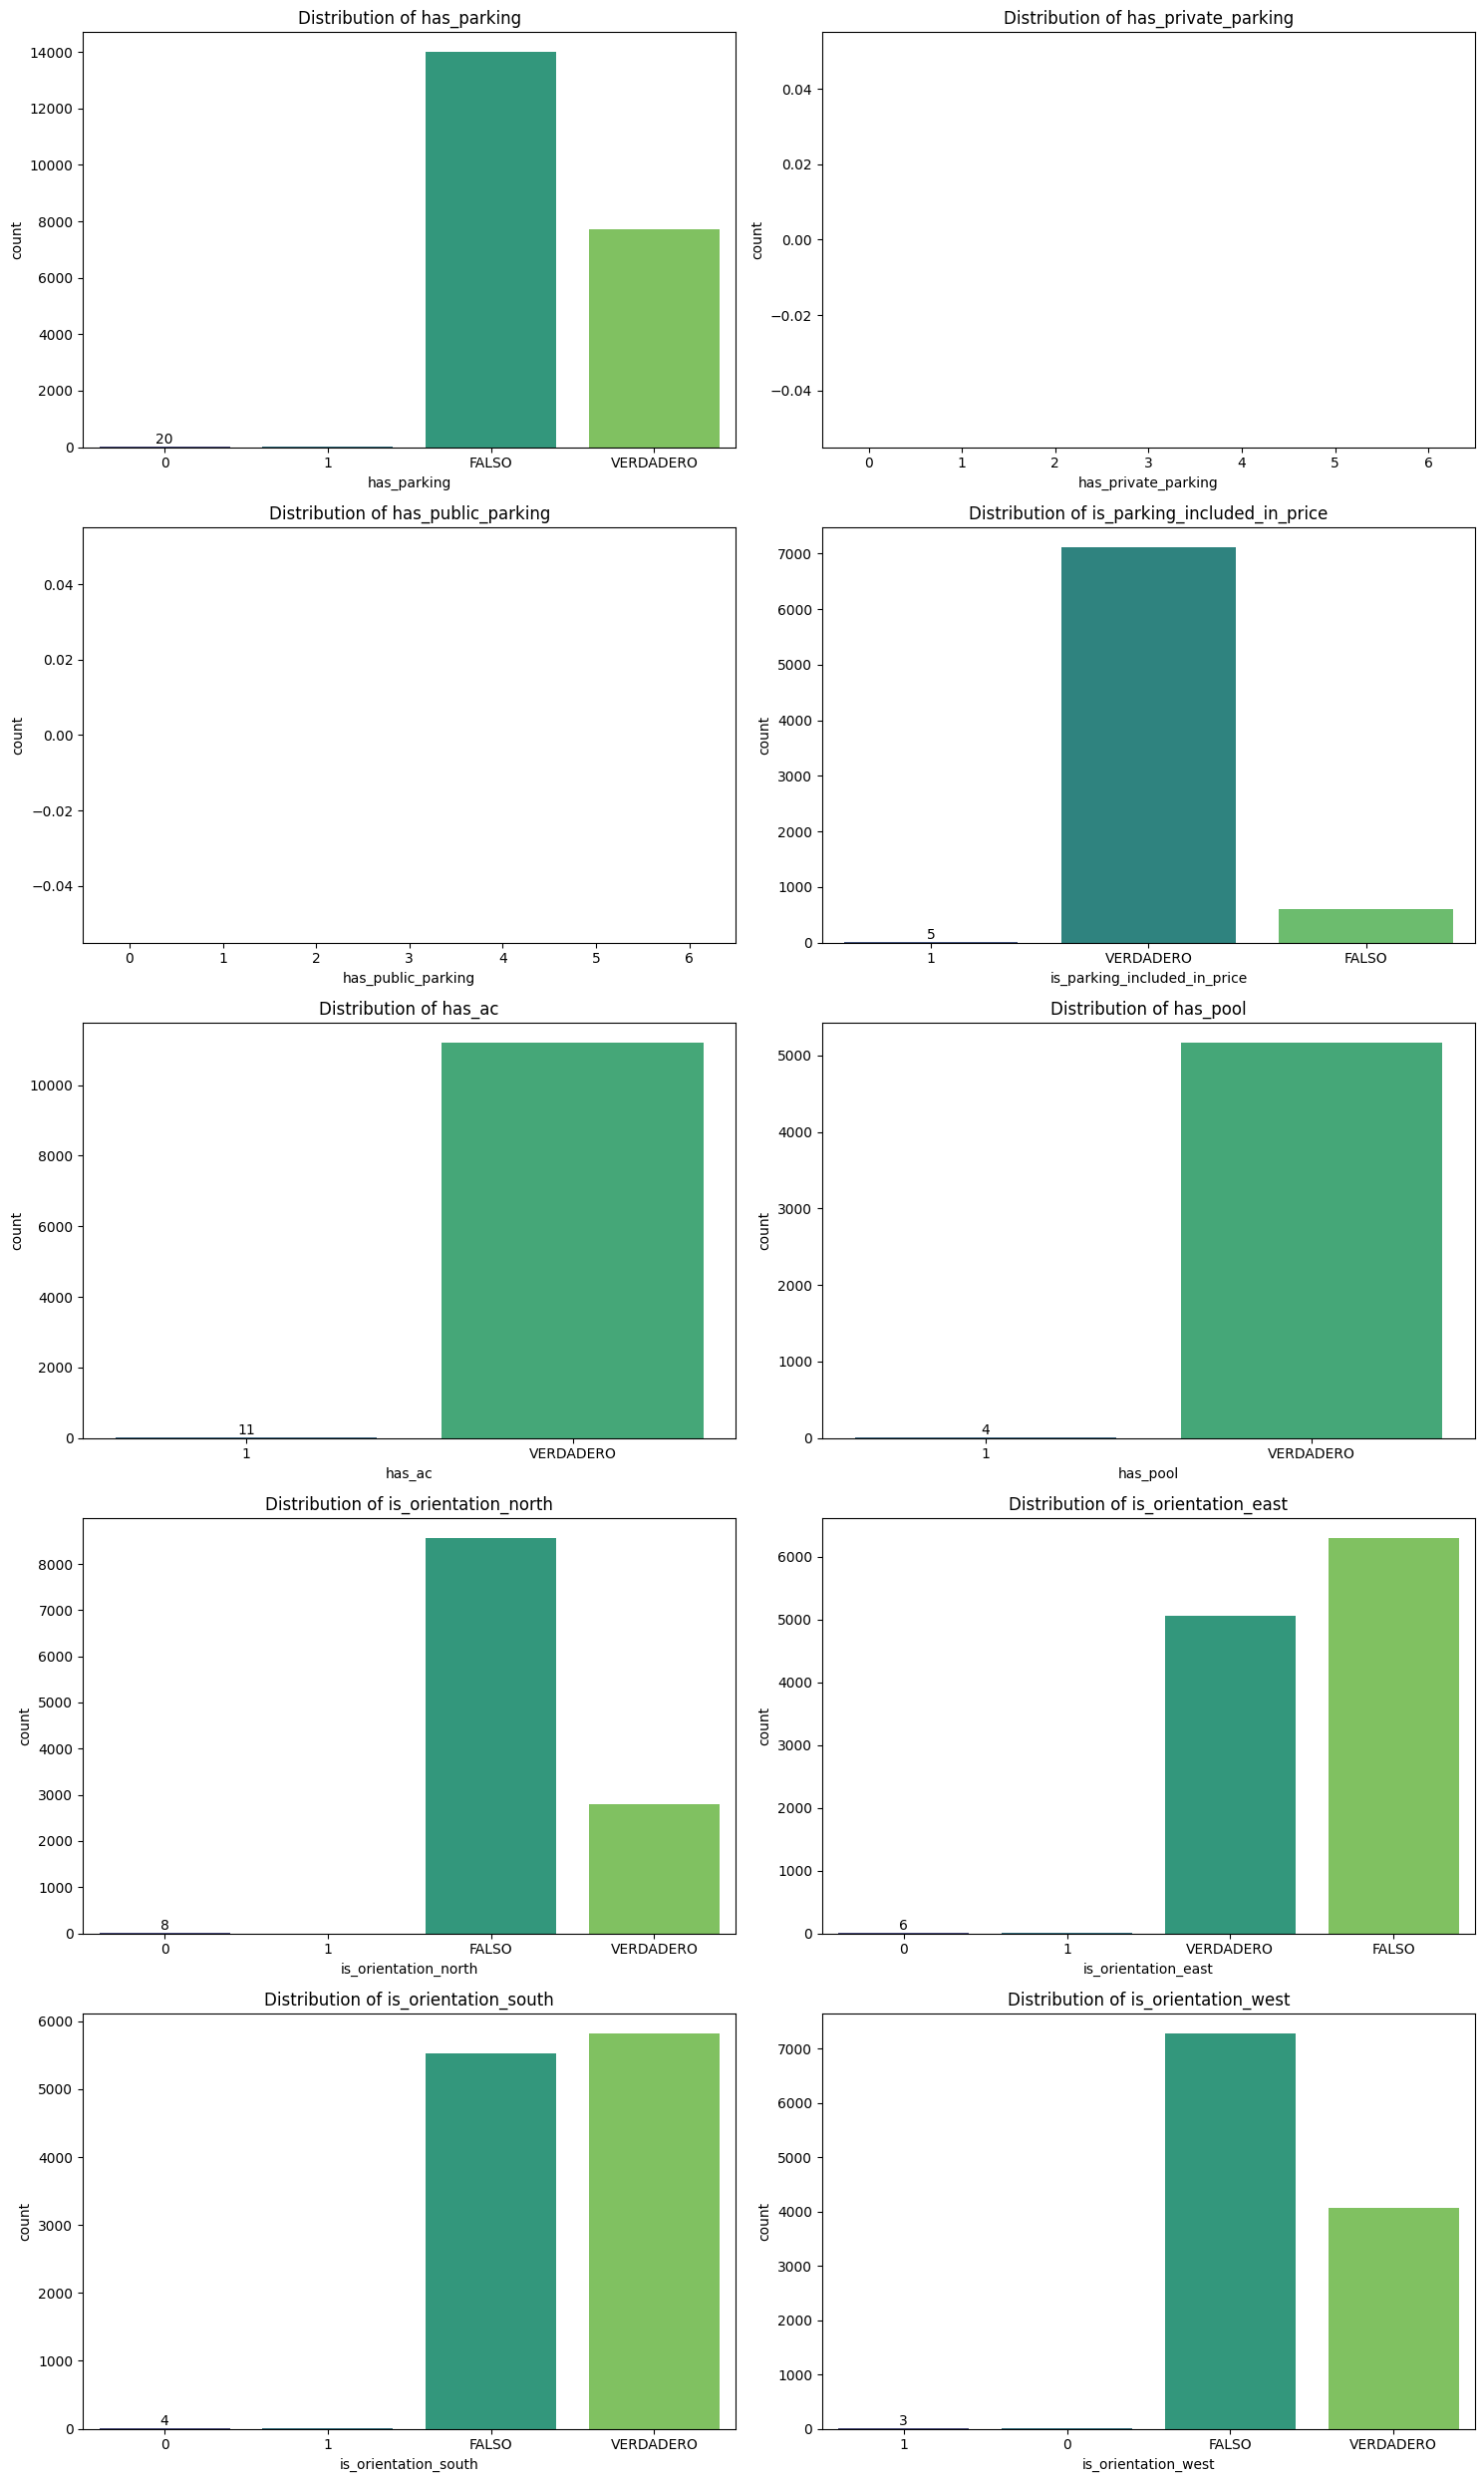

In [355]:
columns_to_analyze = ['has_parking', 'has_private_parking', 'has_public_parking', 'is_parking_included_in_price', 'has_ac', 'has_pool', 'is_orientation_north', 'is_orientation_east', 'is_orientation_south', 'is_orientation_west']

for column in columns_to_analyze:
    print(f"Distinct values in {column}:")
    print(df[column].value_counts(dropna=False))
    print('---------')

# Get the columns we're working with
columns_to_plot = columns_to_analyze
print(f"Columns being plotted: {columns_to_plot}")

# Create a grid of subplots with 2 columns
num_cols = len(columns_to_plot)
cols = 2
rows = num_cols // cols  # Calculate rows needed (ceiling division)
fig_height = rows * 5  # 5 pixels per row

fig, axes = plt.subplots(rows, cols, figsize=(15, fig_height))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through columns and create plots
for i, column in enumerate(columns_to_plot):
    if i < len(axes):  # Make sure we don't exceed the number of subplots
        sns.countplot(x=column, data=df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        # Check if the container has elements before trying to label bars
        if axes[i].containers and len(axes[i].containers) > 0:
            axes[i].bar_label(axes[i].containers[0])

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

We now impute the binary variables: has_balcony, has_terrace, and is_exterior. Let's first display information about these columns:

Valores únicos en is_exterior:
is_exterior
VERDADERO    16900
NaN           3043
FALSO         1777
1               22
Name: count, dtype: int64
---------
Valores únicos en has_terrace:
has_terrace
NaN          12194
VERDADERO     9534
1               14
Name: count, dtype: int64
---------
Valores únicos en has_balcony:
has_balcony
NaN          18421
VERDADERO     3319
1                2
Name: count, dtype: int64
---------


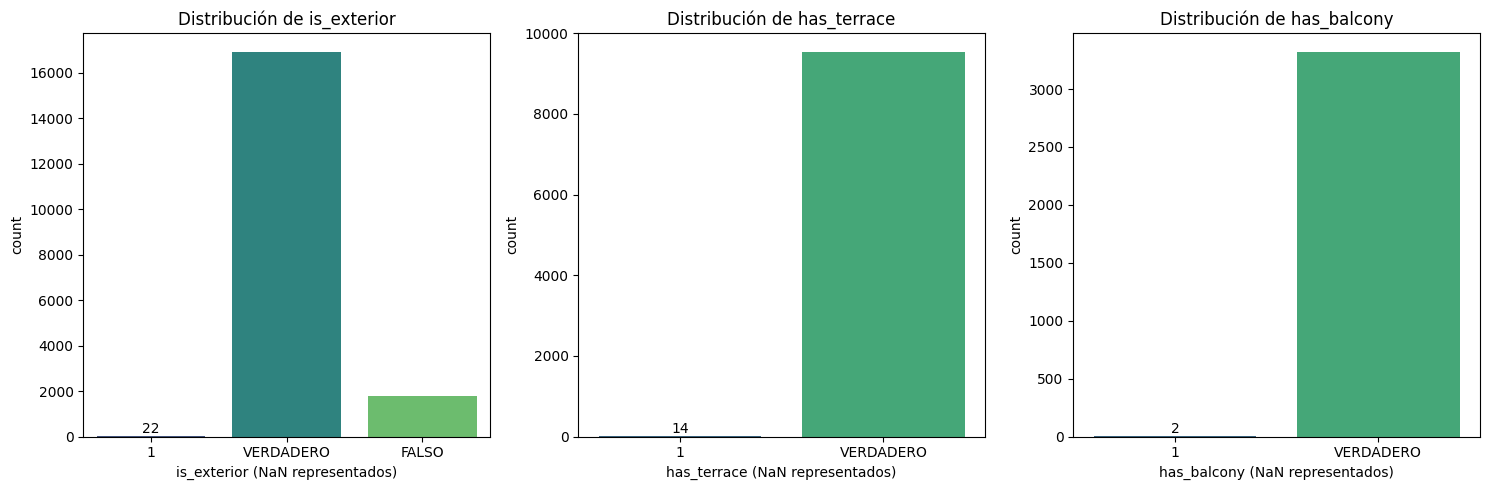

In [356]:
print("Valores únicos en is_exterior:")
print(df['is_exterior'].value_counts(dropna=False))
print('---------')

print("Valores únicos en has_terrace:")
print(df['has_terrace'].value_counts(dropna=False))
print('---------')

print("Valores únicos en has_balcony:")
print(df['has_balcony'].value_counts(dropna=False))
print('---------')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x='is_exterior', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Distribución de is_exterior')
axes[0].set_xlabel('is_exterior (NaN representados)')
axes[0].bar_label(axes[0].containers[0])

sns.countplot(x='has_terrace', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Distribución de has_terrace')
axes[1].set_xlabel('has_terrace (NaN representados)')
axes[1].bar_label(axes[1].containers[0])

sns.countplot(x='has_balcony', data=df, ax=axes[2], palette='viridis')
axes[2].set_title('Distribución de has_balcony')
axes[2].set_xlabel('has_balcony (NaN representados)')
axes[2].bar_label(axes[2].containers[0])

plt.tight_layout()
plt.show()  

## Column preprocessing

### Preprocess floor column

#### Standarization


Value counts
floor
 9.0     181
 8.0     326
 7.0     556
 6.0     913
 5.0    1310
 4.0    2323
 3.0    3001
 2.0    3546
 1.0    4440
 0.5     271
 0.0    2144
-0.5      92
-1.0      32
 NaN    2607
Name: count, dtype: int64
------------------------------------------------------------------------------
Mean: 2.6151816043898615
Median: 2.0
------------------------------------------------------------------------------


<Axes: title={'center': 'Floor distribution'}, ylabel='Frequency'>

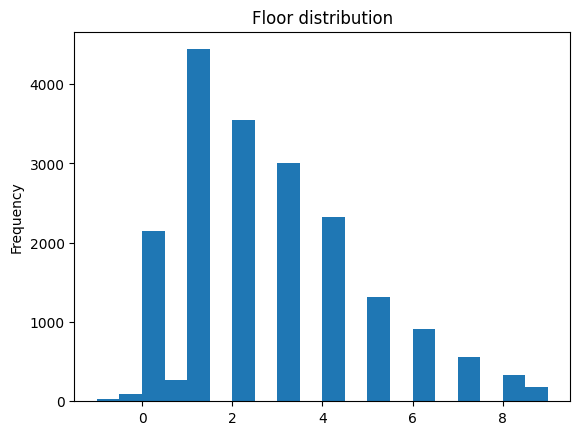

In [357]:
floor_map = {
    'Bajo': 0,
    'Entreplanta': 0.5,
    'Entreplanta interior': 0.5,
    'Entreplanta exterior': 0.5,
    'Semi-sótano': -0.5,
    'Semi-sótano interior': -0.5,
    'Semi-sótano exterior': -0.5,
    'Sótano': -1,
    'Sótano interior': -1,
    'Sótano exterior': -1
}

df['floor'] = df['floor'].replace(floor_map)
df['floor'] = pd.to_numeric(df['floor'], errors='coerce')

print("Value counts")
print(df['floor'].value_counts(dropna=False).sort_index(ascending=False))
print("------------------------------------------------------------------------------")
print("Mean:", df['floor'].mean())
print("Median:", df['floor'].median())
print("------------------------------------------------------------------------------")

df['floor'].plot(kind='hist', bins=20, title='Floor distribution')

#### Imputation of missing values

In [358]:
# 1. CORRELATION WITH NUMERIC FEATURES
original_df['floor'] = df['floor']
numeric_corr = original_df.corr(numeric_only=True)['floor'].drop('floor').sort_values(key=abs, ascending=False)

print("\n🔵 Numeric features most correlated with 'floor':")
print(numeric_corr)

# 2. VISUALIZE TOP CORRELATED NUMERIC FEATURES
top_numeric_features = numeric_corr[abs(numeric_corr) > 0.3].index  # threshold can be changed
if not top_numeric_features.empty:
    sns.pairplot(original_df, vars=top_numeric_features.tolist() + ['floor'])
    plt.show()

# 3. CORRELATION WITH CATEGORICAL FEATURES
categorical_cols = original_df.select_dtypes(include='object').columns  # object dtype = usually categorical

print("\n🟠 Average 'floor' by categorical feature:")
for col in categorical_cols:
    means = original_df.groupby(col)['floor'].mean().sort_values()
    print(f"\n{col}:\n{means}")

pvalues = []

for col in categorical_cols:
    groups = [group['floor'].dropna() for name, group in original_df.groupby(col)]
    if len(groups) > 1:
        f_val, p_val = scipy.stats.f_oneway(*groups)
        pvalues.append((col, p_val))

pvalues = sorted(pvalues, key=lambda x: x[1], reverse=True)


for pvalue in pvalues:
    print(f"ANOVA for {pvalue[0]}: p-value = {pvalue[1]}")


🔵 Numeric features most correlated with 'floor':
buy_price              0.157148
sq_mt_useful           0.151508
buy_price_by_area      0.148571
sq_mt_built            0.147173
n_rooms                0.146561
n_bathrooms            0.125489
built_year             0.034052
Unnamed: 0             0.025749
id                    -0.025749
parking_price          0.023478
rent_price            -0.023263
n_floors                    NaN
sq_mt_allotment             NaN
latitude                    NaN
longitude                   NaN
portal                      NaN
door                        NaN
rent_price_by_area          NaN
is_rent_price_known         NaN
are_pets_allowed            NaN
is_furnished                NaN
is_kitchen_equipped         NaN
has_private_parking         NaN
has_public_parking          NaN
Name: floor, dtype: float64

🟠 Average 'floor' by categorical feature:

title:
title
Piso en venta en General diaz porlier                     -1.0
Estudio en venta en calle de Bravo

No numeric column was found with sufficient correlation to conclude that they are related (values < 0.3). 

Because of that, we will just be using categorical columns with very small p-values. 
The column with the lowest p-value is is_floor_under, which has null values, and the second one is neighbourhood_id. We will group by neighbourhood_id and then impute with the median for that group.

In [359]:
valid_floors = df['floor'].dropna().unique()

def snap_to_valid_floor(x, valid_floors):
    if pd.isna(x):
        return np.nan

    return valid_floors[np.abs(valid_floors - x).argmin()]

df['floor'] = df['floor'].fillna(
    original_df.groupby(['neighborhood_id'])['floor'].transform('median')
)

# We remove values invented by the median (for instance, 2.5)
df['floor'] = df['floor'].apply(lambda x: snap_to_valid_floor(x, valid_floors))

We check that all the null values were properly imputed into valid values. Also, we can see that the distribution has remained almost the same.

Value counts
floor
 9.0     181
 8.0     326
 7.0     556
 6.0     913
 5.0    1310
 4.0    2348
 3.0    3721
 2.0    4886
 1.0    4962
 0.5     271
 0.0    2144
-0.5      92
-1.0      32
Name: count, dtype: int64
------------------------------------------------------------------------------
Mitjana: 2.552824027228406
Mediana: 2.0
------------------------------------------------------------------------------


<Axes: title={'center': 'Floor distribution'}, ylabel='Frequency'>

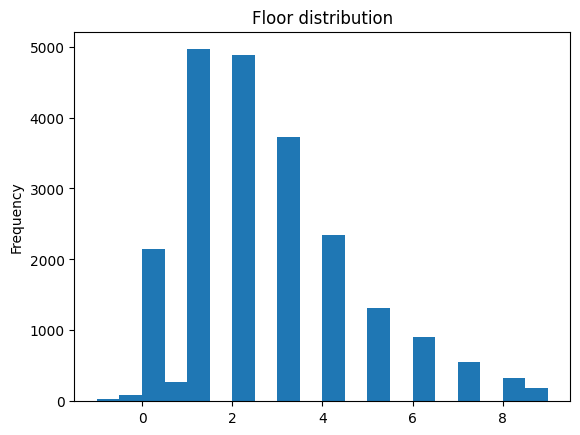

In [360]:
print("Value counts")
print(df['floor'].value_counts(dropna=False).sort_index(ascending=False))
print("------------------------------------------------------------------------------")
print("Mitjana:", df['floor'].mean())
print("Mediana:", df['floor'].median())
print("------------------------------------------------------------------------------")

df['floor'].plot(kind='hist', bins=20, title='Floor distribution')

### Preprocess n_rooms
#### Normalization

<Axes: title={'center': 'Distribución n_rooms después'}, ylabel='Frequency'>

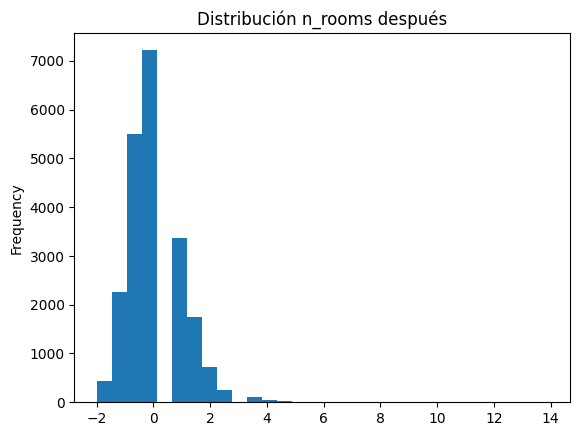

In [361]:
scaler = StandardScaler()
df['n_rooms'] = scaler.fit_transform(df[['n_rooms']])
df['n_rooms'].plot(kind='hist', bins=30, title='Distribución n_rooms después')

### Preprocess sq_mt_built column
#### Standarization, renaming, normalization and imputation

Mitjana: 146.9208919319023
Mediana: 100.0


<Axes: title={'center': 'Distribución sq_meters_built before'}, ylabel='Frequency'>

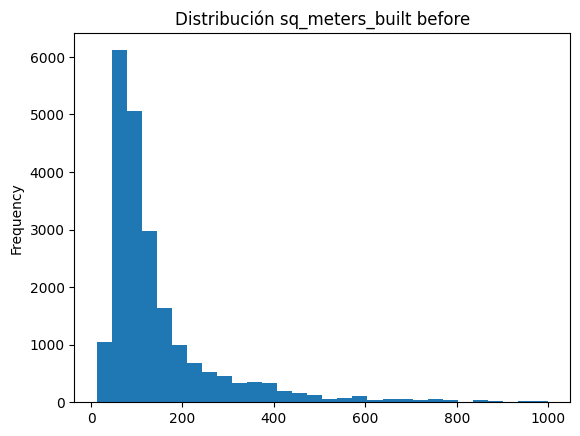

In [362]:
print("Mitjana:", df['sq_mt_built'].mean())
print("Mediana:", df['sq_mt_built'].median())
df['sq_mt_built'].plot(kind='hist', bins=30, title='Distribución sq_meters_built before')

We notice that there are some outliers, so it's best to use the median for the imputation

<Axes: title={'center': 'Distribución sq_meters_built after'}, ylabel='Frequency'>

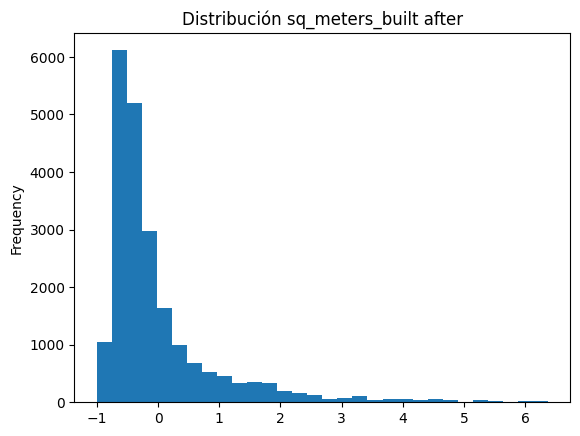

In [363]:
df['sq_mt_built'] = df['sq_mt_built'].fillna(df['sq_mt_built'].median())
scaler = StandardScaler()
df['sq_mt_built'] = scaler.fit_transform(df[['sq_mt_built']])
df['sq_mt_built'].plot(kind='hist', bins=30, title='Distribución sq_meters_built after')

### Preprocess sq_mt_useful column
#### Standarization, renaming, normalization and imputation

Mitjana: 103.45819154107924
Mediana: 79.0


<Axes: title={'center': 'Distribución sq_meters_useful before'}, ylabel='Frequency'>

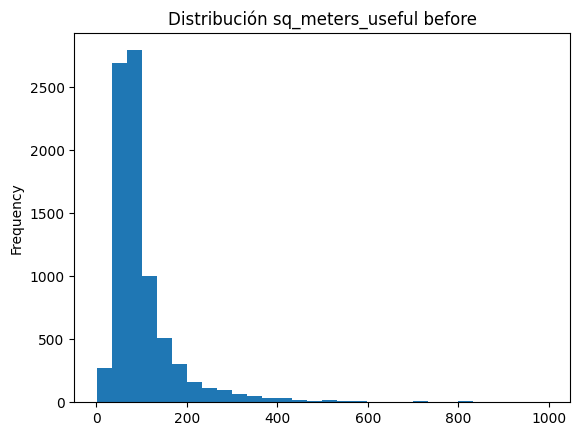

In [364]:
print("Mitjana:", df['sq_mt_useful'].mean())
print("Mediana:", df['sq_mt_useful'].median())
df['sq_mt_useful'].plot(kind='hist', bins=30, title='Distribución sq_meters_useful before')

We notice that there are some outliers, so it's best to use the median. We also see that the data needs to be normalized.

<Axes: title={'center': 'Distribución sq_meters_useful after'}, ylabel='Frequency'>

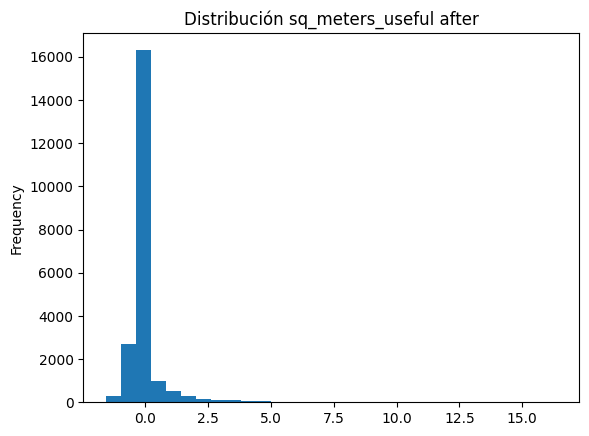

In [365]:
df['sq_mt_useful'] = df['sq_mt_useful'].fillna(df['sq_mt_useful'].median())
scaler = StandardScaler()
df['sq_mt_useful'] = scaler.fit_transform(df[['sq_mt_useful']])
df['sq_mt_useful'].plot(kind='hist', bins=30, title='Distribución sq_meters_useful after')

### Preprocess has_lift column
#### Standarization, renaming and imputation

has_lift
VERDADERO    14885
FALSO         4448
0               13
1               10
Name: count, dtype: int64


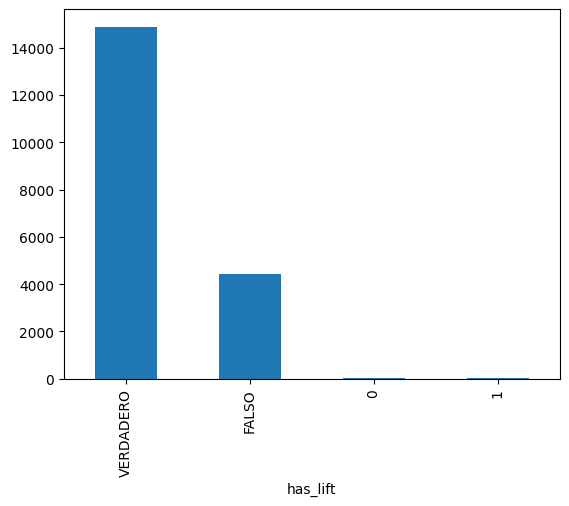

In [366]:
conteo = df['has_lift'].value_counts()
print(conteo)

df['has_lift'].value_counts().plot(kind='bar')
plt.show()

We impute null values ​​for has_lift. Since cases where it is unknown whether there is an elevator or not may be related to older, cheaper apartments, we create a new category, "unknown," represented by the number 2. We also see that some tuples have values ​​like "TRUE" or "FALSE," and others have "1" or "0." We leave all with 1 for true, 0 for false, and 2 for unknown values.

has_lift
1    14895
0     4461
2     2386
Name: count, dtype: int64


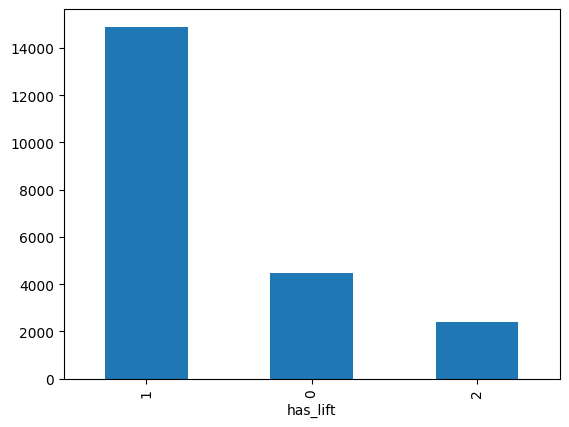

In [367]:
df['has_lift'] = df['has_lift'].fillna('unknown')
df['has_lift'] = df['has_lift'].astype(str)

df['has_lift'] = df['has_lift'].replace({
    'VERDADERO': '1',
    'FALSO': '0',
    'True': '1',
    'False': '0',
    'true': '1',
    'false': '0'
})
valores_validos = {'0', '1'}
df['has_lift'] = df['has_lift'].apply(lambda x: x if x in valores_validos else 'unknown')
df['has_lift'] = df['has_lift'].map({'0': 0, '1': 1, 'unknown': 2})
print(df['has_lift'].value_counts())

df['has_lift'].value_counts().plot(kind='bar')
plt.show()

### Preprocess house type column

#### Standarization and renaming

In [368]:
house_type_map = {
    'HouseType 1: Pisos' : 'Piso',
    'HouseType 2: Casa o chalet' : 'Casa',
    'HouseType 5: Áticos': 'Ático',
    'HouseType 4: Dúplex': 'Dúplex',
}

df['house_type'] = df['house_type_id'].replace(house_type_map)

print("Valores únicos en house_type:")
print(df['house_type'].value_counts(dropna=False))

Valores únicos en house_type:
house_type
Piso      17705
Casa       1938
Ático      1032
Dúplex      676
NaN         391
Name: count, dtype: int64


#### Imputation of missing values

Hay muy pocos valores nulos, de modo que podemos permitirnos imputarlos por la mediana.

Valores únicos en house_type:
house_type
Piso      18096
Casa       1938
Ático      1032
Dúplex      676
Name: count, dtype: int64


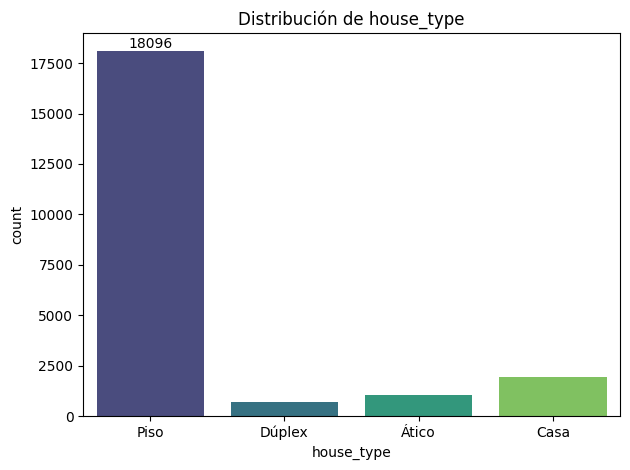

In [369]:
df['house_type'].fillna(df['house_type'].mode()[0], inplace=True)

print("Valores únicos en house_type:")
print(df['house_type'].value_counts(dropna=False))

fig, axes = plt.subplots(1, 1)
sns.countplot(x='house_type', data=df, ax=axes, palette='viridis')
axes.set_title('Distribución de house_type')
axes.set_xlabel('house_type')
axes.bar_label(axes.containers[0])

plt.tight_layout()
plt.show()

#### Encoding

In [370]:
df = pd.get_dummies(df, columns=['house_type'], dtype='uint8')

print("\nCounts of house type columns:")
print(df[['house_type_Casa', 'house_type_Dúplex', 'house_type_Piso', 'house_type_Ático']].sum())


Counts of house type columns:
house_type_Casa       1938
house_type_Dúplex      676
house_type_Piso      18096
house_type_Ático      1032
dtype: uint64


### Preprocess heating_type column

#### Standarization and renaming

In [371]:
def determine_heating_type(row):
    if str(row['has_central_heating']).upper() in ['VERDADERO', '1']:
        return 'central'
    elif str(row['has_individual_heating']).upper() in ['VERDADERO', '1']:
        return 'individual'
    else:
        return 'unknown'

# Apply the function
df['heating_type'] = df.apply(determine_heating_type, axis=1)

print("Valores únicos en heating_type:")
print(df['heating_type'].value_counts(dropna=False))

Valores únicos en heating_type:
heating_type
individual    9516
unknown       8134
central       4092
Name: count, dtype: int64


#### Encoding

In [372]:
df = pd.get_dummies(df, columns=['heating_type'], dtype='uint8')

print("\nCounts of heating type columns:")
print(df[['heating_type_central', 'heating_type_individual', 'heating_type_unknown']].sum())


Counts of heating type columns:
heating_type_central       4092
heating_type_individual    9516
heating_type_unknown       8134
dtype: uint64


### Preprocess street name column

#### Imputation of null values

In [373]:
df['street_name'] = df['street_name'].fillna('unknown')

print("Valores únicos en street_name:")
print(df['street_name'].value_counts(dropna=False))


Valores únicos en street_name:
street_name
unknown                                 5905
Paseo de la Castellana                   116
Calle de Bravo Murillo                    69
Calle del Príncipe de Vergara             60
Calle de Embajadores                      58
                                        ... 
Calle Peonias                              1
Calle de Hermenegildo Bielsa               1
Avenida de los arces                       1
Calle del Estrecho de Mesina, Madrid       1
Calle Burriana                             1
Name: count, Length: 6163, dtype: int64


We can see that there are 6163 columns, a lot of them with one one row of representation. Also, almost one third of the rows have an unknown street_name.

Consequently, we have decided to not use this column for the further training and classification.

### Preprocess floor column

#### Standarization

### Final processing

### Preprocess has pool column

#### Standarization and renaming

In [374]:
has_pool_map = {
    '1' : 1,
    'VERDADERO' : 1,
}

df['has_pool'] = df['has_pool'].replace(has_pool_map)

print("Valores únicos en has_pool:")
print(df['has_pool'].value_counts(dropna=False))

Valores únicos en has_pool:
has_pool
NaN    16571
1.0     5171
Name: count, dtype: int64


#### Imputation of missing values

The missing values are false values.

In [375]:
df['has_pool'].fillna(0, inplace=True)

print("Valores únicos en has_pool:")
print(df['has_pool'].value_counts(dropna=False))

Valores únicos en has_pool:
has_pool
0.0    16571
1.0     5171
Name: count, dtype: int64


### Preprocess has air conditioner column

#### Standarization and renaming

In [376]:
has_ac_map = {
    '1' : 1,
    'VERDADERO' : 1,
}

df['has_ac'] = df['has_ac'].replace(has_ac_map)

print("Valores únicos en has_ac:")
print(df['has_ac'].value_counts(dropna=False))

Valores únicos en has_ac:
has_ac
1.0    11211
NaN    10531
Name: count, dtype: int64


#### Imputation of missing values
There are no missing values

In [377]:
df['has_ac'].fillna(0, inplace=True)

print("Valores únicos en has_ac:")
print(df['has_ac'].value_counts(dropna=False))

Valores únicos en has_ac:
has_ac
1.0    11211
0.0    10531
Name: count, dtype: int64


### Preprocess has parking column

#### Explanation of different source of variables

There are 4 columns from the original dataset that describe things about the parking.

has_private_parking and has_public_parking do not provide any relevant information as all of their values are missing.

is_parking_included_in_price does not provide any extra information neither because all the available parkings are included in the price, so only has_parking provides valuable information.

In [378]:
# Count parkings that are not included in price
parkings_not_included = df[(df['has_parking'].isin(['1', 'VERDADERO'])) & 
                           (df['is_parking_included_in_price'].isna())].shape[0]

# Additional counts for context
parkings_included = df[(df['has_parking'].isin(['1', 'VERDADERO'])) & 
                       (df['is_parking_included_in_price'].notna())].shape[0]
total_parkings = df[df['has_parking'].isin(['1', 'VERDADERO'])].shape[0]

print("\nParking inclusion analysis:")
print(f"Parkings not included in price: {parkings_not_included}")
print(f"Parkings included in price: {parkings_included}")
print(f"Total properties with parking: {total_parkings}")


Parking inclusion analysis:
Parkings not included in price: 0
Parkings included in price: 7719
Total properties with parking: 7719


#### Standarization and renaming

In [379]:
has_parking_map = {
    '1' : 1,
    'VERDADERO' : 1,
    'FALSO' : 0,
    '0' : 0,
}

df['has_parking'] = df['has_parking'].replace(has_parking_map)

print("Valores únicos en has_parking:")
print(df['has_parking'].value_counts(dropna=False))

Valores únicos en has_parking:
has_parking
0    14023
1     7719
Name: count, dtype: int64


#### Imputation of missing values

There are no missing values.

### Preprocess orientation column

#### Standarization and renaming

In [380]:
orientation_map = {
    '1' : 1,
    'VERDADERO' : 1,
}

for col in ORIENTATION_COLUMNS:
    df[col] = df[col].replace(orientation_map)

def combine_orientations(row):
    north = row['is_orientation_north']
    east = row['is_orientation_east']
    south = row['is_orientation_south']
    west = row['is_orientation_west']
    
    if north == 1 and east == 1 and south == 1 and west == 1:
        return 'all'
    
    orientations = []
    if north == 1:
        orientations.append('north')
    if east == 1:
        orientations.append('east')
    if south == 1:
        orientations.append('south')
    if west == 1:
        orientations.append('west')
    
    if not orientations:
        return 'unknown'
    
    return '-'.join(orientations)

df['orientation'] = df.apply(combine_orientations, axis=1)
print("Valores únicos en orientation:")
print(df['orientation'].value_counts(dropna=False))

Valores únicos en orientation:
orientation
unknown             10384
south                2522
east                 1797
west                 1383
east-south           1164
east-west             763
north                 744
south-west            711
north-south           530
all                   500
north-east            437
north-west            336
east-south-west       227
north-east-south       93
north-south-west       76
north-east-west        75
Name: count, dtype: int64


#### Imputation of missing values

As it is a categorical column, missing values have been converted to a new unknown class.

### Preprocess buy_price column (answer variable)

#### Analysis of the variable

Distinct values in buy_price:
buy_price
550000     170
135000     149
650000     146
130000     139
160000     138
          ... 
1879700      1
2279700      1
852000       1
2172000      1
388000       1
Name: count, Length: 2403, dtype: int64


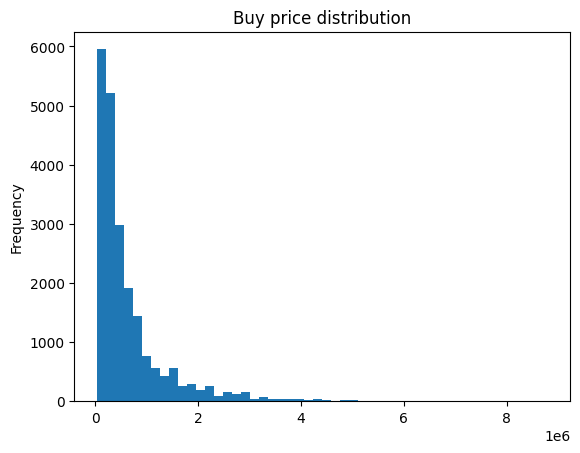

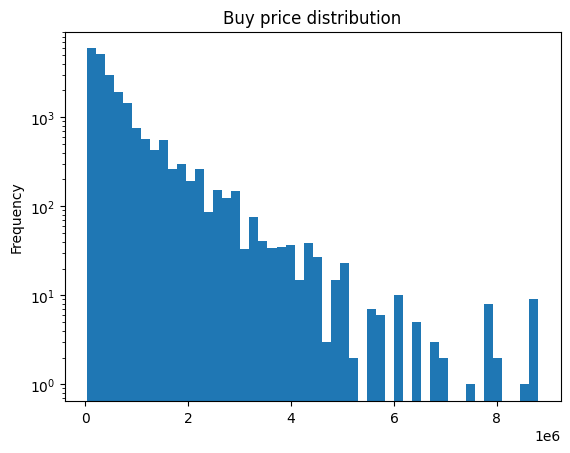

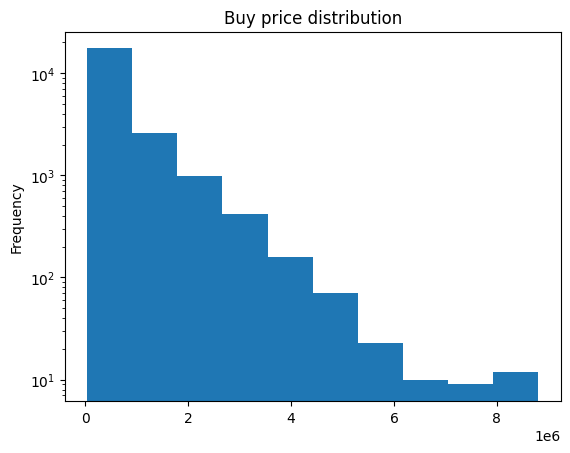

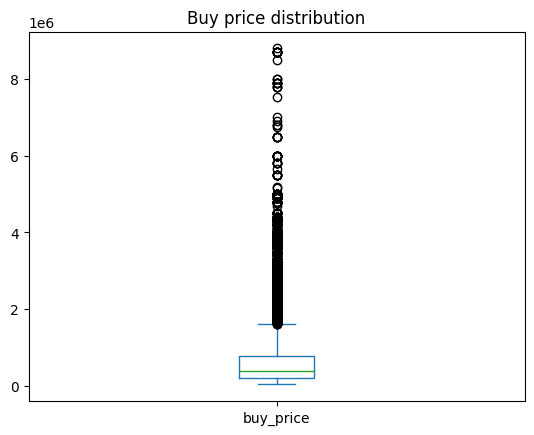

In [381]:
print("Distinct values in buy_price:")
print(df['buy_price'].value_counts(dropna=False))

df['buy_price'].plot(kind='hist', bins=50, title='Buy price distribution')
plt.show()
# Plot with logarithmic scale
df['buy_price'].plot(kind='hist', bins=50, title='Buy price distribution', logy=True)
plt.show()
# Plot with logarithmic scale and 10 bins
df['buy_price'].plot(kind='hist', bins=10, title='Buy price distribution', logy=True)
plt.show()
# Plot with boxplot
df['buy_price'].plot(kind='box', title='Buy price distribution')
plt.show()

#### Discretize the values

In [382]:
labels = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High']

# Preprocess
df['price_category'], bins = pd.qcut(df['buy_price'], 
                                     q=5, 
                                     labels=labels, 
                                     retbins=True)

Low: [36000.0, 175000.0)
Medium-Low: [175000.0, 288000.0)
Medium: [288000.0, 495000.0)
Medium-High: [495000.0, 899000.0)
High: [899000.0, 8800000.0)


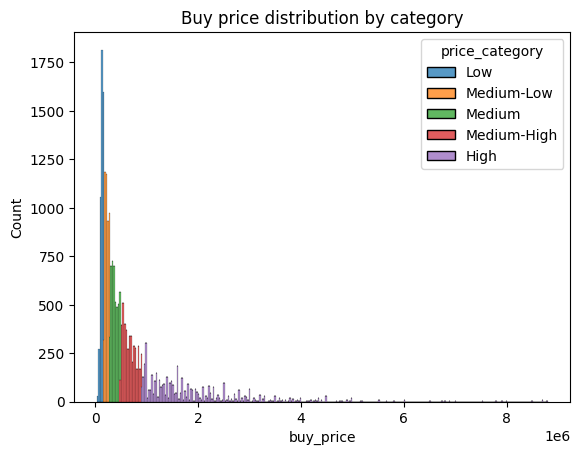

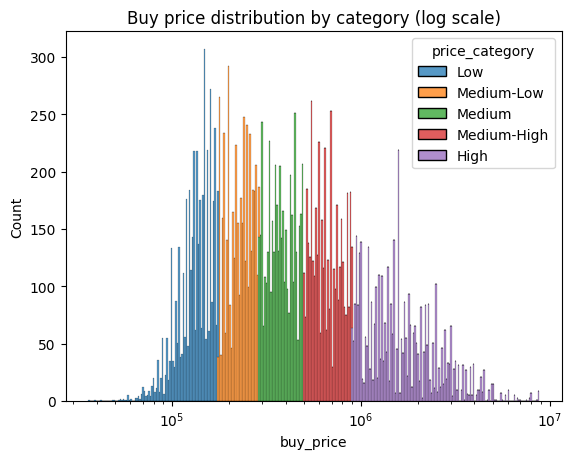

In [383]:
for i, label in enumerate(labels):
    print(f"{labels[i]}: [{bins[i]}, {bins[i+1]})")

sns.histplot(data=df, 
             x='buy_price', 
             hue='price_category', 
             bins=300, 
             log_scale=False, 
             multiple='stack')
plt.title('Buy price distribution by category')
plt.show()

sns.histplot(data=df, 
             x='buy_price', 
             hue='price_category', 
             bins=300, 
             log_scale=True, 
             multiple='stack')
plt.title('Buy price distribution by category (log scale)')
plt.show()

### Preprocess is_exterior, has_terrace and has_balcony

In [384]:
df[['is_exterior', 'has_terrace', 'has_balcony']] = df[['is_exterior', 'has_terrace', 'has_balcony']].replace({'VERDADERO': 1, 'FALSO': 0})

df['is_exterior'] = df['is_exterior'].fillna(2)
df['has_terrace'] = df['has_terrace'].fillna(2)
df['has_balcony'] = df['has_balcony'].fillna(2)

df['is_exterior'] = df['is_exterior'].astype(int)
df['has_terrace'] = df['has_terrace'].astype(int)
df['has_balcony'] = df['has_balcony'].astype(int)

Valores únicos en is_exterior:
is_exterior
1    16922
2     3043
0     1777
Name: count, dtype: int64
---------
Valores únicos en has_terrace:
has_terrace
2    12194
1     9548
Name: count, dtype: int64
---------
Valores únicos en has_balcony:
has_balcony
2    18421
1     3321
Name: count, dtype: int64
---------


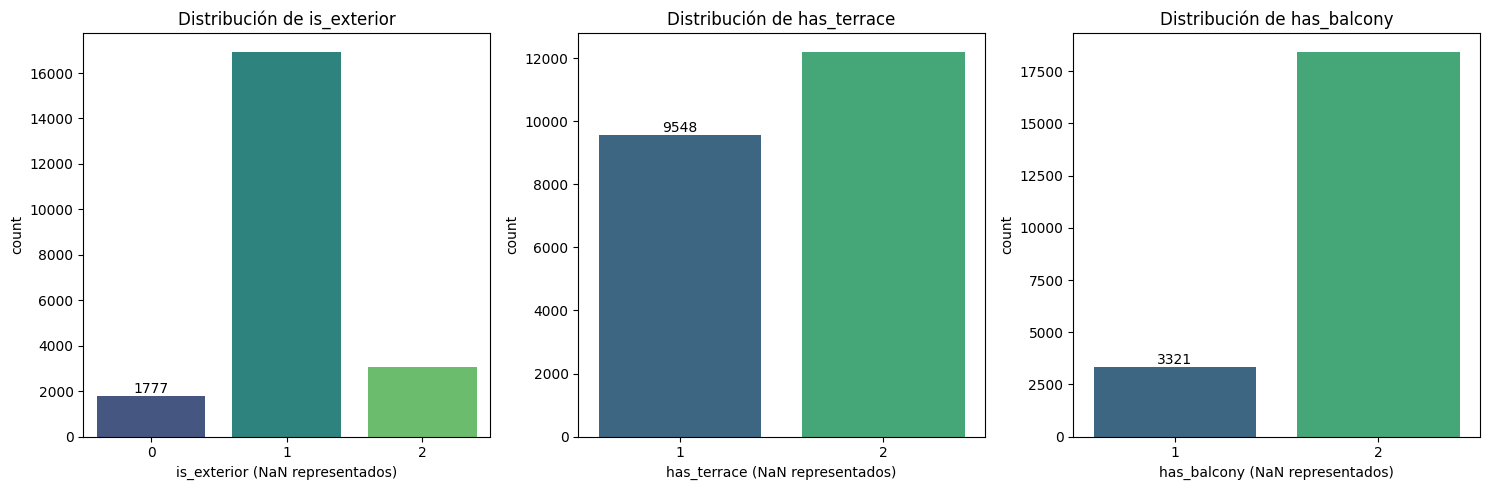

In [385]:
print("Valores únicos en is_exterior:")
print(df['is_exterior'].value_counts(dropna=False))
print('---------')

print("Valores únicos en has_terrace:")
print(df['has_terrace'].value_counts(dropna=False))
print('---------')

print("Valores únicos en has_balcony:")
print(df['has_balcony'].value_counts(dropna=False))
print('---------')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x='is_exterior', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Distribución de is_exterior')
axes[0].set_xlabel('is_exterior (NaN representados)')
axes[0].bar_label(axes[0].containers[0])

sns.countplot(x='has_terrace', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Distribución de has_terrace')
axes[1].set_xlabel('has_terrace (NaN representados)')
axes[1].bar_label(axes[1].containers[0])

sns.countplot(x='has_balcony', data=df, ax=axes[2], palette='viridis')
axes[2].set_title('Distribución de has_balcony')
axes[2].set_xlabel('has_balcony (NaN representados)')
axes[2].bar_label(axes[2].containers[0])

plt.tight_layout()
plt.show()

### Preprocessing built_year


--- Análisis estadístico de built_year ---
Media: 1970.0464
Mediana: 1970.0
Desviación estándar: 69.38670548837041
Mínimo: 1723.0
Máximo: 8170.0
Rango: 6447.0
Percentil 25%: 1957.0
Percentil 75%: 1994.0

Los 10 años de construcción más frecuentes:
built_year
1960.0    515
1970.0    481
1900.0    446
1965.0    434
1950.0    255
1968.0    209
2007.0    191
2006.0    190
2008.0    189
2005.0    185
Name: count, dtype: int64


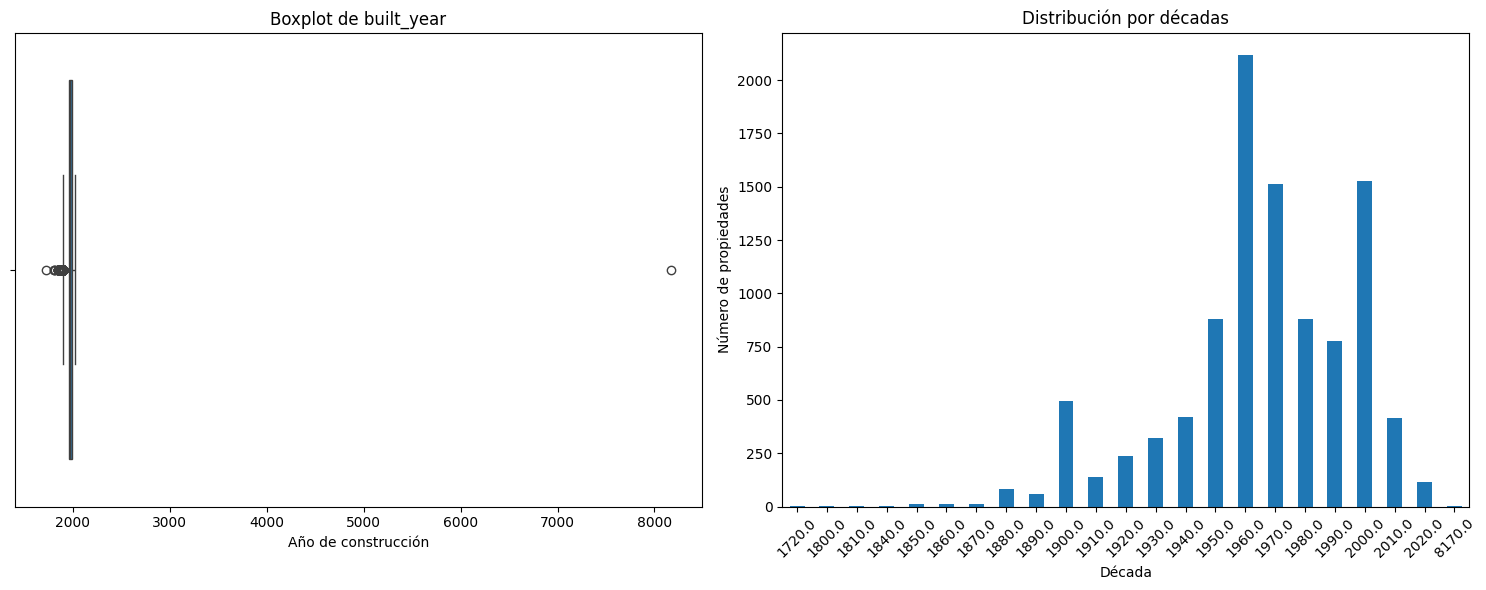

In [386]:
print("\n--- Análisis estadístico de built_year ---")
print(f"Media: {df['built_year'].mean()}")
print(f"Mediana: {df['built_year'].median()}")
print(f"Desviación estándar: {df['built_year'].std()}")
print(f"Mínimo: {df['built_year'].min()}")
print(f"Máximo: {df['built_year'].max()}")
print(f"Rango: {df['built_year'].max() - df['built_year'].min()}")
print(f"Percentil 25%: {df['built_year'].quantile(0.25)}")
print(f"Percentil 75%: {df['built_year'].quantile(0.75)}")

# Top años más frecuentes
top_years = df['built_year'].value_counts().head(10)
print("\nLos 10 años de construcción más frecuentes:")
print(top_years)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot para visualizar outliers
sns.boxplot(x=df['built_year'], ax=axes[0])
axes[0].set_title('Boxplot de built_year')
axes[0].set_xlabel('Año de construcción')

# Histograma por décadas
df['decade'] = (df['built_year'] // 10) * 10
decades_count = df['decade'].value_counts().sort_index()
decades_count.plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribución por décadas')
axes[1].set_xlabel('Década')
axes[1].set_ylabel('Número de propiedades')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

if 'decade' in df.columns:
    df.drop('decade', axis=1, inplace=True)

From the above information, we draw the following conclusions:
1. The median and the 25th and 75th percentiles are very close to the year 1970, indicating that many buildings were built during that period.
2. There is an extreme value of 8170, which is clearly an error.
3. There also appear to be some outliers in years prior to 1850, which will be left in to preserve historical context.

So, we'll delete this row with the extreme value of 8170 and impute the null values ​​using KNN. We'll do this with this algorithm because taking the mean or median when there are so many null values ​​can affect the distribution.

Para el KNN, veamos la correlación con el resto de variables:

Columna house_type_id codificada con one-hot encoding: 3 nuevas columnas
Columna energy_certificate codificada con one-hot encoding: 9 nuevas columnas

Columnas numéricas válidas para correlación: 37

Top 30 correlaciones con 'built_year':
built_year                      1.000000
n_floors                        0.358472
has_pool                        0.205661
has_parking                     0.200935
is_parking_included_in_price    0.200768
has_green_zones                 0.151061
has_storage_room                0.144615
id                              0.124171
has_terrace                     0.101163
has_fitted_wardrobes            0.099326
has_garden                      0.082523
is_accessible                   0.077237
sq_mt_allotment                 0.076795
has_ac                          0.071328
n_bathrooms                     0.066458
sq_mt_useful                    0.064400
sq_mt_built                     0.056167
floor                           0.031443
n_rooms               

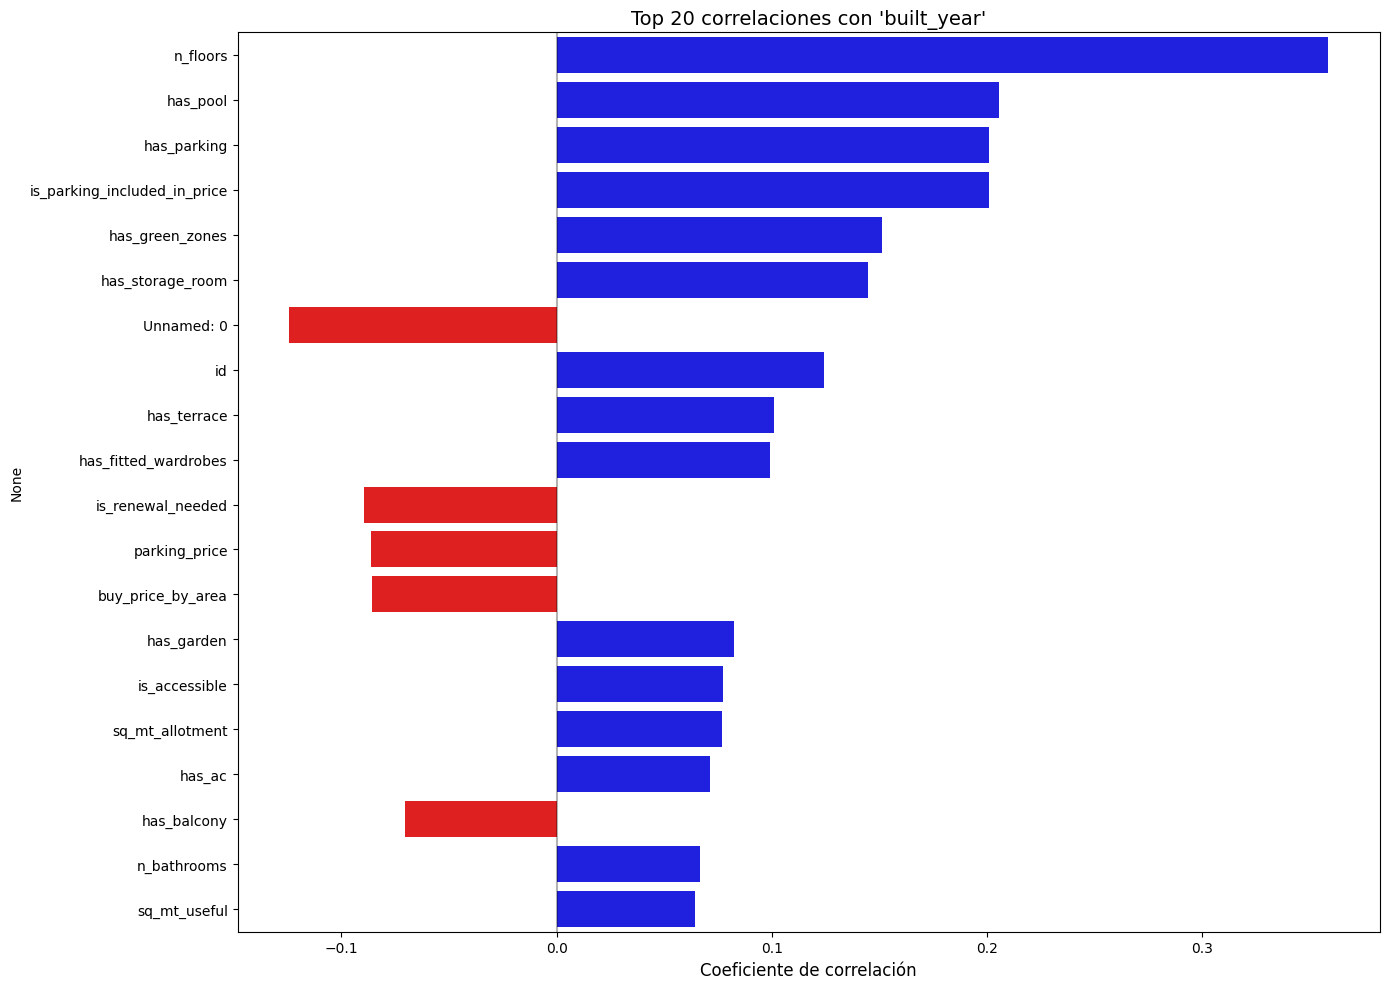

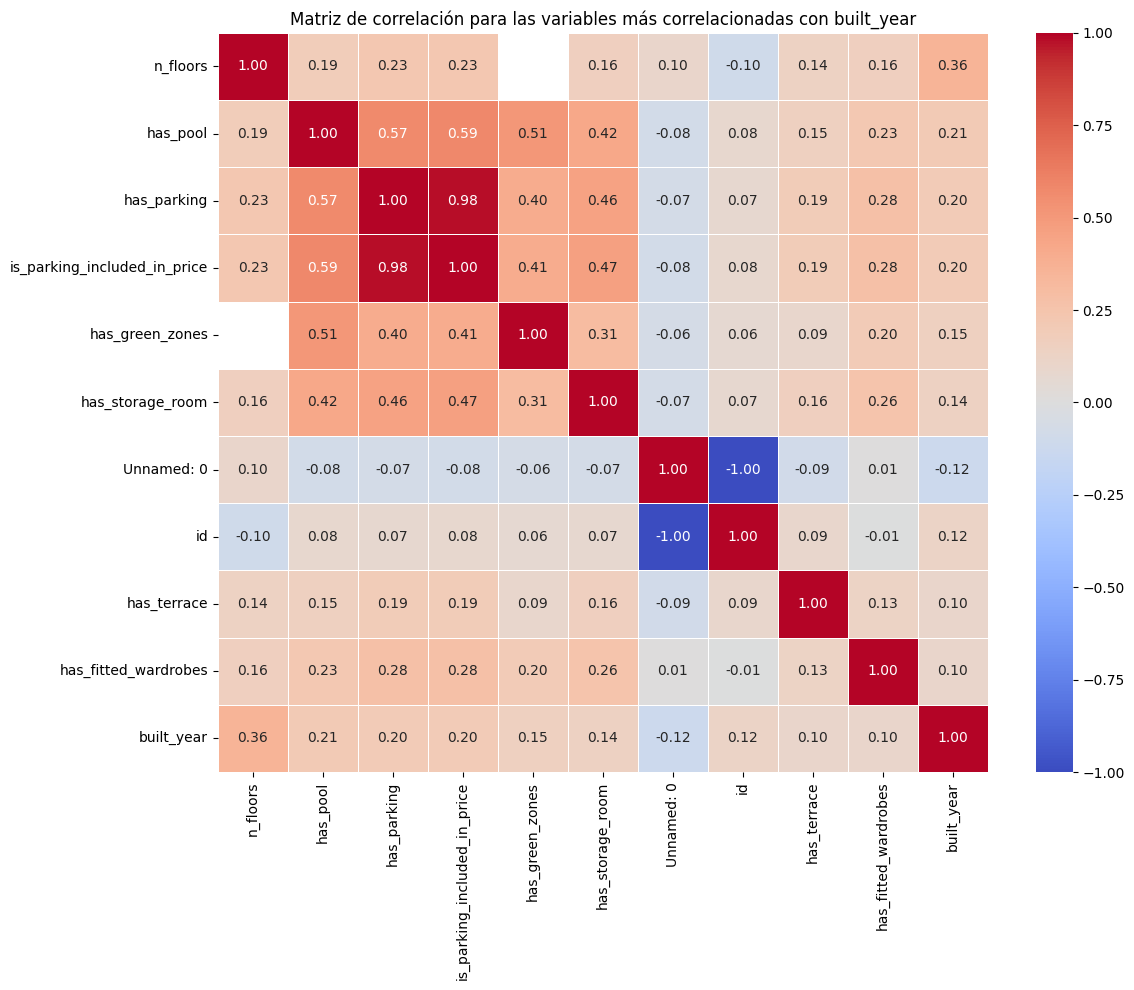

In [387]:
# Volvemos a cargar el dataset completo para analizar correlaciones
df_full = pd.read_csv('../data/dataset.csv')

# Convertir variables booleanas
boolean_columns = [
    'is_rent_price_known', 'are_pets_allowed', 'is_furnished', 
    'is_kitchen_equipped', 'has_private_parking', 'has_public_parking',
    'is_exterior', 'has_terrace', 'has_balcony'
]

for col in boolean_columns:
    if col in df_full.columns:
        df_full[col] = df_full[col].replace({
            'VERDADERO': 1, 'FALSO': 0, 
            'True': 1, 'False': 0,
            True: 1, False: 0,
            'true': 1, 'false': 0
        })
        df_full[col] = pd.to_numeric(df_full[col], errors='coerce').fillna(-1).astype('float')

# Convertir más columnas categóricas potencialmente booleanas
additional_boolean_columns = [
    'has_central_heating', 'has_individual_heating', 'has_ac',
    'has_fitted_wardrobes', 'has_lift', 'has_garden', 'has_pool',
    'has_storage_room', 'is_accessible', 'has_green_zones',
    'has_parking', 'is_parking_included_in_price',
    'is_orientation_north', 'is_orientation_west', 
    'is_orientation_south', 'is_orientation_east',
    'is_renewal_needed', 'is_new_development', 'is_buy_price_known',
    'is_exact_address_hidden', 'is_floor_under'
]

for col in additional_boolean_columns:
    if col in df_full.columns:
        df_full[col] = df_full[col].replace({
            'VERDADERO': 1, 'FALSO': 0, 
            'True': 1, 'False': 0,
            'Si': 1, 'No': 0,
            'SI': 1, 'NO': 0,
            'YES': 1, 'NO': 0,
            'Yes': 1, 'No': 0,
            'S': 1, 'N': 0,
            'Y': 1, 'N': 0,
            True: 1, False: 0
        })
        df_full[col] = pd.to_numeric(df_full[col], errors='coerce').fillna(-1).astype('float')

# Convertir columnas numéricas que están como object
numeric_object_cols = [
    'floor', 'latitude', 'longitude'
]

for col in numeric_object_cols:
    if col in df_full.columns:
        df_full[col] = pd.to_numeric(df_full[col], errors='coerce')

# Usar one-hot encoding para variables categóricas con pocos valores únicos
categorical_cols = [
    'operation', 'house_type_id', 'energy_certificate', 'neighborhood_id'
]

for col in categorical_cols:
    if col in df_full.columns:
        # Solo codificar si hay menos de 30 categorías para evitar demasiadas columnas
        unique_values = df_full[col].nunique()
        if unique_values < 30 and unique_values > 1:
            # Crear dummies y eliminar una categoría para evitar la trampa de las variables dummy
            dummies = pd.get_dummies(df_full[col], prefix=col, drop_first=True)
            df_full = pd.concat([df_full, dummies], axis=1)
            print(f"Columna {col} codificada con one-hot encoding: {dummies.shape[1]} nuevas columnas")

# Eliminar filas con built_year NaN para la correlación
correlation_df = df_full.dropna(subset=['built_year']).copy()

# Seleccionar solo las columnas numéricas
numeric_cols = correlation_df.select_dtypes(include=['number']).columns
valid_cols = []

for col in numeric_cols:
    # Filtrar columnas con suficientes datos y varianza
    if (correlation_df[col].notna().sum() > 100 and  # al menos 100 valores no nulos
        correlation_df[col].nunique() > 1):          # más de 1 valor único
        valid_cols.append(col)

print(f"\nColumnas numéricas válidas para correlación: {len(valid_cols)}")

# Calcular correlaciones y mostrar top 30
if 'built_year' in valid_cols:
    correlation_matrix = correlation_df[valid_cols].corr(method='pearson')
    built_year_corr = correlation_matrix['built_year'].sort_values(ascending=False)
    
    print("\nTop 30 correlaciones con 'built_year':")
    print(built_year_corr.head(30))
    
    # Visualizar top 20 correlaciones
    plt.figure(figsize=(14, 10))
    top_corrs = built_year_corr.drop('built_year').abs().sort_values(ascending=False).head(20)
    top_corrs_actual = built_year_corr[top_corrs.index]
    
    # Crear un gráfico de barras ordenado por valor absoluto pero mostrando valores reales
    colors = ['red' if x < 0 else 'blue' for x in top_corrs_actual]
    sns.barplot(x=top_corrs_actual.values, y=top_corrs_actual.index, palette=colors)
    plt.title("Top 20 correlaciones con 'built_year'", fontsize=14)
    plt.xlabel("Coeficiente de correlación", fontsize=12)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Crear una matriz de correlación visual para las top variables
    top_cols = list(top_corrs_actual.index[:10]) + ['built_year']
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_df[top_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', 
                linewidths=0.5, center=0)
    plt.title("Matriz de correlación para las variables más correlacionadas con built_year")
    plt.tight_layout()
    plt.show()
else:
    print("Error: 'built_year' no está entre las columnas numéricas válidas")

A continuación aplicamos KNN con las variables más correlacionadas:


Verificando que no queden nulos en las características:
n_floors                        0
has_pool                        0
has_parking                     0
is_parking_included_in_price    0
has_green_zones                 0
has_storage_room                0
has_terrace                     0
has_fitted_wardrobes            0
has_garden                      0
is_accessible                   0
sq_mt_allotment                 0
has_ac                          0
n_bathrooms                     0
is_floor_under                  0
dtype: int64

Porcentaje de valores imputados: 54.01%


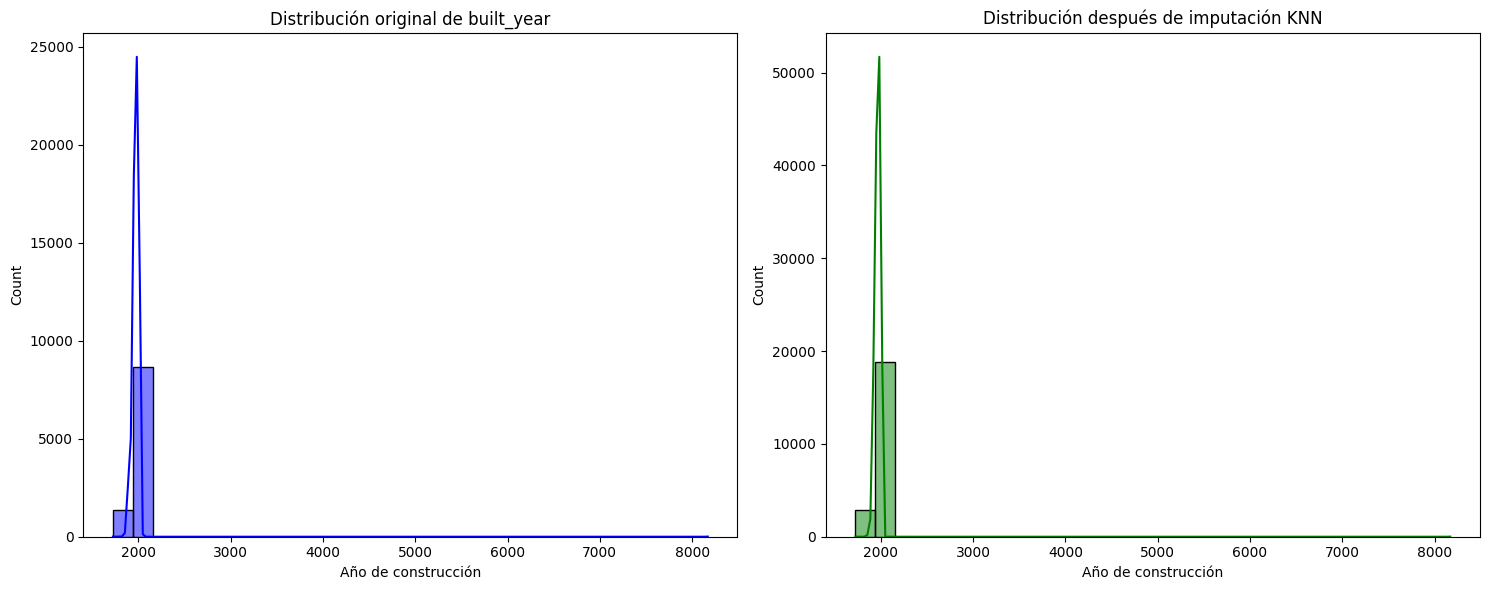

In [388]:
# Seleccionar las características más correlacionadas con built_year para la imputación
features_for_imputation = [
    'n_floors', 'has_pool', 'has_parking', 'is_parking_included_in_price',
    'has_green_zones', 'has_storage_room', 'has_terrace', 
    'has_fitted_wardrobes', 'has_garden', 'is_accessible',
    'sq_mt_allotment', 'has_ac', 'n_bathrooms', 'is_floor_under'
]

# Crear un nuevo DataFrame temporal
# Combinamos las columnas relevantes de df_full con el índice de df
imputation_data = pd.DataFrame(index=df.index)
imputation_data['built_year'] = df['built_year'].copy()

# Añadir las columnas de características desde df_full
for col in features_for_imputation:
    if col in df_full.columns:
        imputation_data[col] = df_full.loc[df.index, col].copy()

available_features = [col for col in features_for_imputation if col in imputation_data.columns]

# Imputar valores nulos en las características (no en built_year)
for col in available_features:
    if imputation_data[col].isnull().sum() > 0:
        # Para características binarias (-1, 0, 1)
        if imputation_data[col].nunique() <= 3:
            most_common = imputation_data[col].mode().iloc[0]
            imputation_data[col].fillna(most_common, inplace=True)
        # Para características numéricas
        else:
            imputation_data[col].fillna(imputation_data[col].median(), inplace=True)

print("\nVerificando que no queden nulos en las características:")
print(imputation_data[available_features].isnull().sum())

# Estandarizar las características para que tengan la misma escala
scaler = StandardScaler()
features_scaled = scaler.fit_transform(imputation_data[available_features])
imputation_scaled = pd.DataFrame(features_scaled, columns=available_features, index=imputation_data.index)
imputation_scaled['built_year'] = imputation_data['built_year']

# Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=7)
imputed_array = imputer.fit_transform(imputation_scaled)

# Convertir el resultado a DataFrame con los mismos índices
imputed_df = pd.DataFrame(imputed_array, columns=imputation_scaled.columns, index=imputation_scaled.index)

# Guardar una copia de los años originales antes de la imputación
built_year_original = df['built_year'].copy()

# Actualizar SOLO los valores nulos en df
mask_null = df['built_year'].isna()
df.loc[mask_null, 'built_year'] = imputed_df.loc[mask_null, 'built_year']
df['built_year'] = df['built_year'].round().astype(int)

print(f"\nPorcentaje de valores imputados: {mask_null.mean() * 100:.2f}%")

# Visualizar la distribución antes y después de la imputación
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(built_year_original.dropna(), kde=True, bins=30, color='blue')
plt.title('Distribución original de built_year')
plt.xlabel('Año de construcción')

plt.subplot(1, 2, 2)
sns.histplot(df['built_year'], kde=True, bins=30, color='green')
plt.title('Distribución después de imputación KNN')
plt.xlabel('Año de construcción')

plt.tight_layout()
plt.show()


--- Análisis estadístico de built_year ---
Media: 1967.0137068212134
Mediana: 1968.0
Desviación estándar: 28.37667187473942
Mínimo: 1723
Máximo: 2022
Rango: 299
Percentil 25%: 1953.0
Percentil 75%: 1988.0

Los 10 años de construcción más frecuentes:
built_year
1960    805
1918    727
1965    691
1970    648
1962    587
1968    466
1900    446
1966    443
2006    434
1944    401
Name: count, dtype: int64


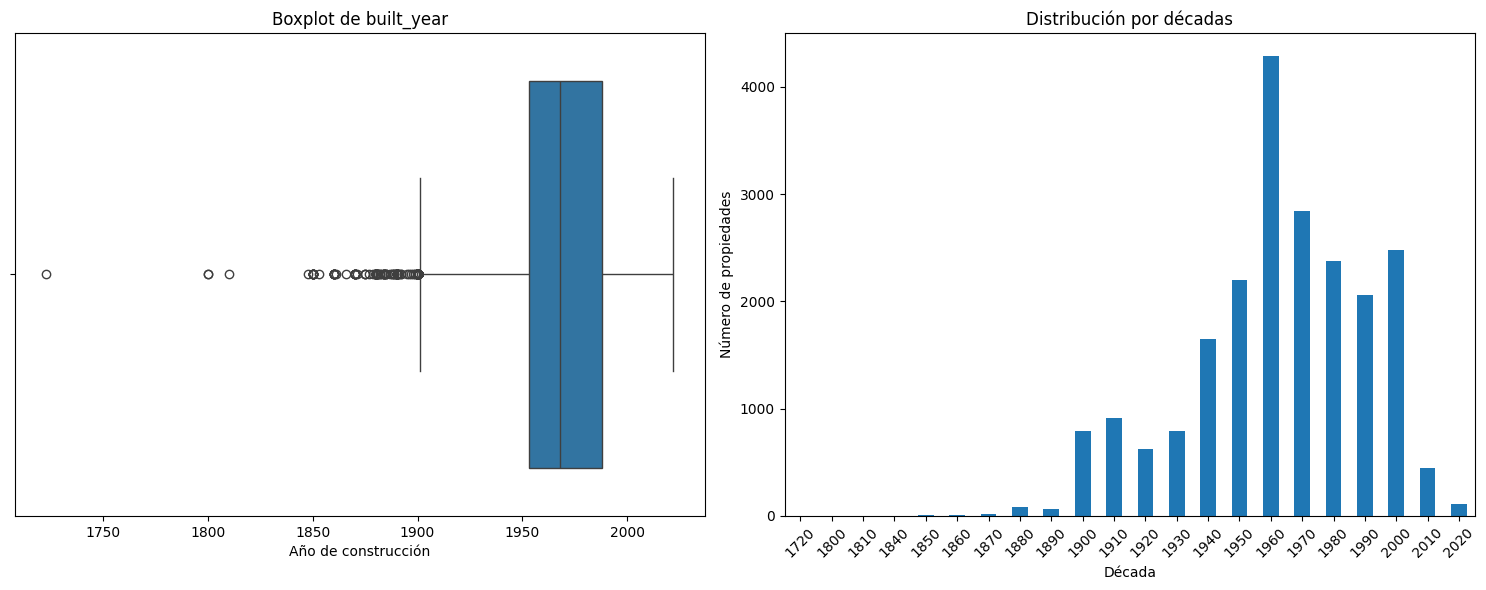

In [389]:
# Eliminamos las posbiles filas que tengan como año de construcción 8170
df = df[df['built_year'] != 8170]

print("\n--- Análisis estadístico de built_year ---")
print(f"Media: {df['built_year'].mean()}")
print(f"Mediana: {df['built_year'].median()}")
print(f"Desviación estándar: {df['built_year'].std()}")
print(f"Mínimo: {df['built_year'].min()}")
print(f"Máximo: {df['built_year'].max()}")
print(f"Rango: {df['built_year'].max() - df['built_year'].min()}")
print(f"Percentil 25%: {df['built_year'].quantile(0.25)}")
print(f"Percentil 75%: {df['built_year'].quantile(0.75)}")

# Top años más frecuentes
top_years = df['built_year'].value_counts().head(10)
print("\nLos 10 años de construcción más frecuentes:")
print(top_years)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot para visualizar outliers
sns.boxplot(x=df['built_year'], ax=axes[0])
axes[0].set_title('Boxplot de built_year')
axes[0].set_xlabel('Año de construcción')

# Histograma por décadas
df['decade'] = (df['built_year'] // 10) * 10
decades_count = df['decade'].value_counts().sort_index()
decades_count.plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribución por décadas')
axes[1].set_xlabel('Década')
axes[1].set_ylabel('Número de propiedades')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

if 'decade' in df.columns:
    df.drop('decade', axis=1, inplace=True)

### Preprocessing neighborhood_id, is_renewal_needed, has_garden, energy_certificate, is_new_development, n_bathrooms, has_lift, built_year, buy_price_by_area

In [390]:
print(df['has_lift'].apply(type).value_counts())

has_lift
<class 'int'>    21741
Name: count, dtype: int64


In [391]:
df['is_new_development'] = df['is_new_development'].replace({
    'FALSO': 0,
    'VERDADERO': 1,
    'False': 0,
    'True': 1,
    'NO': 0,
    'SI': 1
}).astype('float')


In [392]:
print(df['is_renewal_needed'].unique())

df['is_renewal_needed'] = (
    df['is_renewal_needed']
      .replace({'VERDADERO': 1, 'FALSO': 0})
      .astype(int)
)

print(df['is_renewal_needed'].unique())


['0' '1' 'FALSO' 'VERDADERO']
[0 1]


In [393]:
print(df['has_garden'].unique())

# 2) Convertir a booleano y luego a int
df['has_garden'] = (df['has_garden'] == 'VERDADERO').astype(int)

# 3) Verificar que ahora solo haya 0 y 1
print(df['has_garden'].unique())


[nan 'VERDADERO']
[0 1]


In [394]:
# Definir función mejorada
def split_neighborhood_info(text):
    try:
        match = re.match(
            r"Neighborhood (\d+): (.+?) \(([\d.,Nn][\d.,None]*) €/m2\) - District (\d+): (.+)", 
            text
        )
        if match:
            neighborhood_num = int(match.group(1))
            neighborhood_name = match.group(2)
            price_raw = match.group(3)
            # Detectar si es 'None' o un número
            if 'None' in price_raw or 'none' in price_raw:
                price_per_m2 = np.nan
            else:
                price_per_m2 = float(price_raw.replace(',', ''))
            district_id = int(match.group(4))
            district_name = match.group(5)
            return pd.Series([neighborhood_num, neighborhood_name, price_per_m2, district_id, district_name])
        else:
            return pd.Series([None, None, None, None, None])
    except Exception as e:
        print(f"Error processing row: {text}")
        print(e)
        return pd.Series([None, None, None, None, None])

In [395]:
df[['neighborhood_num', 'neighborhood_name', 'price_per_m2', 'district_id', 'district_name']] = df['neighborhood_id'].apply(split_neighborhood_info)

df[['neighborhood_num', 'neighborhood_name', 'price_per_m2', 'district_id', 'district_name']].head()




,neighborhood_num,neighborhood_name,price_per_m2,district_id,district_name
0,135,San Cristóbal,1308.89,21,Villaverde
1,132,Los Ángeles,1796.68,21,Villaverde
2,134,San Andrés,1617.18,21,Villaverde
3,134,San Andrés,1617.18,21,Villaverde
4,133,Los Rosales,1827.79,21,Villaverde


Antes KNN: (21741, 6)
Después KNN: (21741, 6)


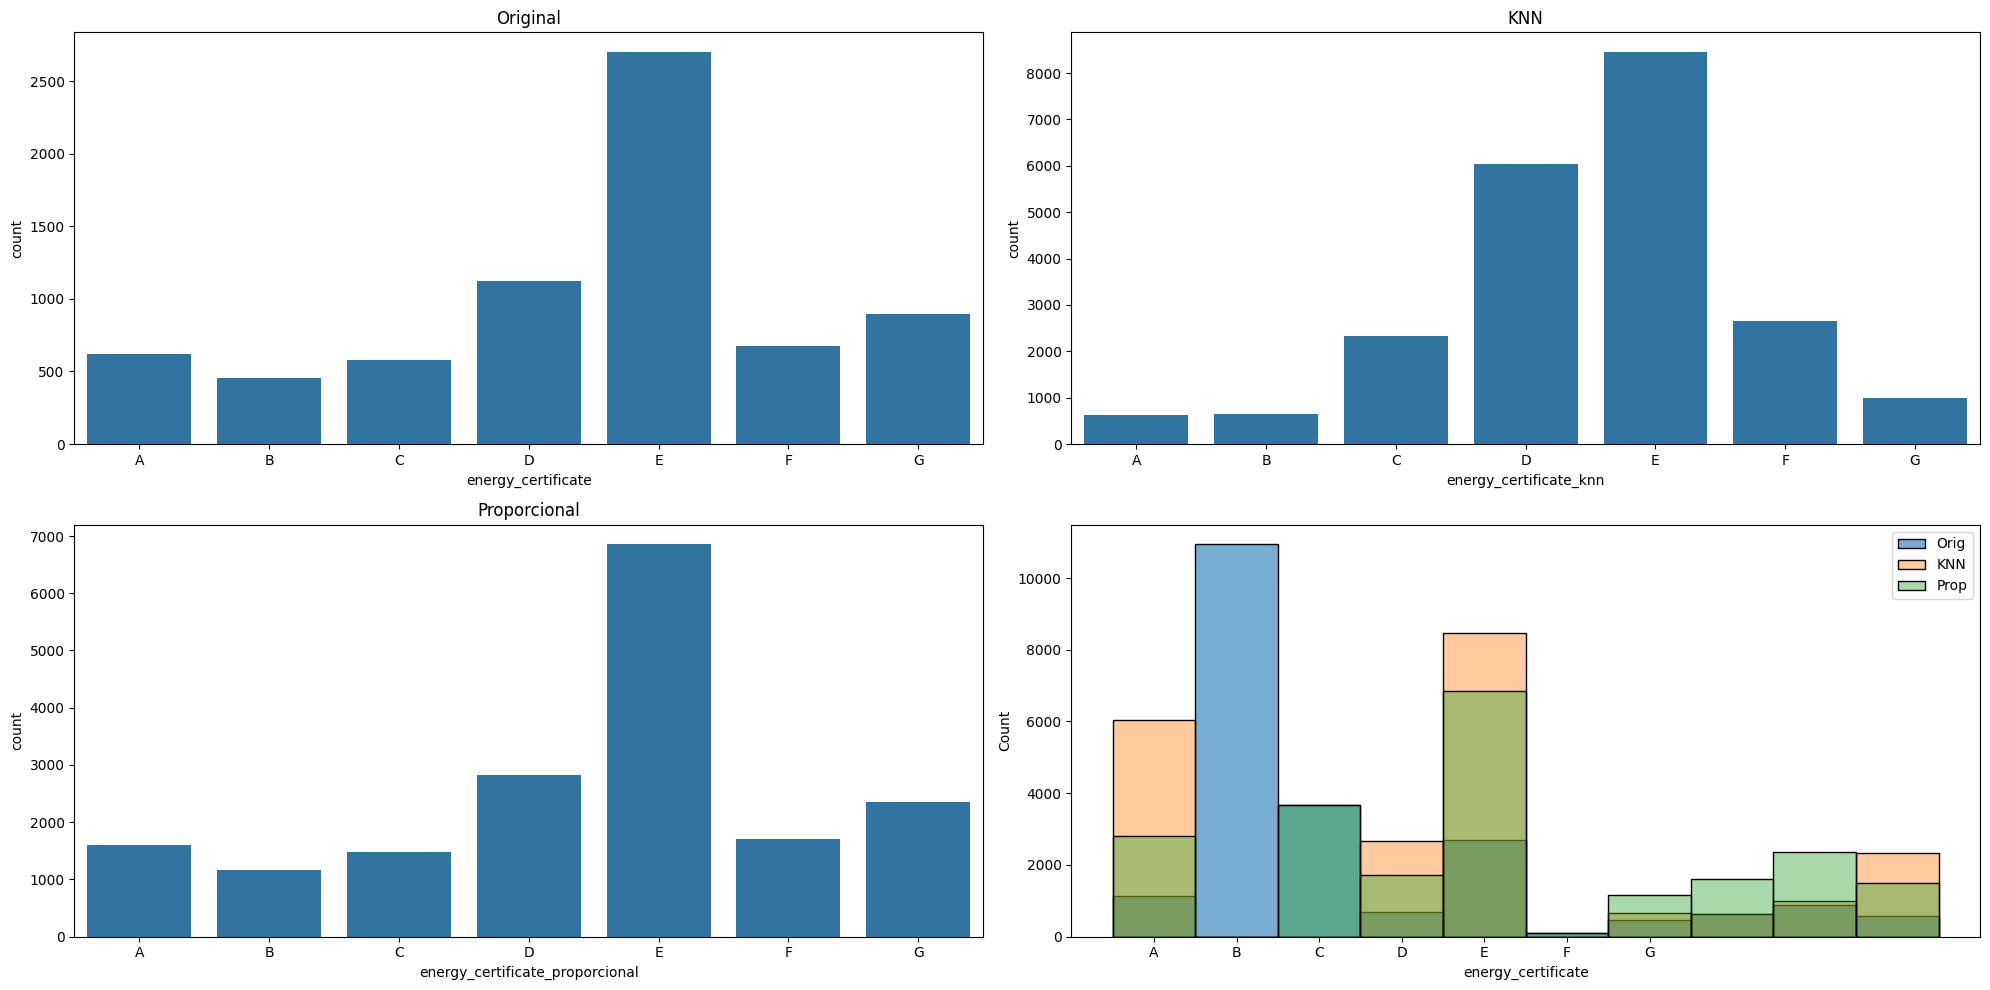

% NaN final en ‘energy_certificate’: 0.00%


In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

# --- 0. Carga tu df antes de esto ---

# --- 1. Lista de certificados válidos ---
cert_vals = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# --- 2. Imputación proporcional por distrito ---
mask_valid = df['energy_certificate'].isin(cert_vals)
dist_por_distrito = (
    df[mask_valid]
    .groupby('district_name')['energy_certificate']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

def imputar_por_distrito(row):
    if row['energy_certificate'] == 'en trámite':
        distrito = row['district_name']
        if distrito in dist_por_distrito.index:
            probs = dist_por_distrito.loc[distrito]
            return np.random.choice(probs.index, p=probs.values)
    return row['energy_certificate']

df['energy_certificate_proporcional'] = df.apply(imputar_por_distrito, axis=1)

# --- 3. Preparación y KNN ---
# 3.1 Mapear booleanos a 1/0 (verifica valores exactos si son 'SI'/'NO', etc.)
boolean_map = {'VERDADERO': 1, 'FALSO': 0, True: 1, False: 0}
df['is_new_development_num'] = df['is_new_development'].map(boolean_map)
df['has_lift_num']           = df['has_lift'].map(boolean_map)

# 3.2 Mapear certificados A–G a 1–7; el resto queda NaN
cert_map = {c: i+1 for i, c in enumerate(cert_vals)}
inv_cert_map = {v: k for k, v in cert_map.items()}
df['energy_certificate_num'] = df['energy_certificate'].map(cert_map)

# 3.3 Selección de features y coerción a float
features = [
    'is_new_development_num',
    'n_bathrooms',
    'has_lift_num',
    'built_year',
    'buy_price_by_area',
    'energy_certificate_num'
]
df_knn = df[features].copy()
df_knn = df_knn.apply(pd.to_numeric, errors='coerce')  # todo a float/NaN

# 3.4 Comprobar forma antes
print("Antes KNN:", df_knn.shape)

imputer = KNNImputer(n_neighbors=5)
knn_array = imputer.fit_transform(df_knn)

# 3.5 Comprobar forma después
print("Después KNN:", knn_array.shape)

df_knn_imputed = pd.DataFrame(knn_array, columns=features)

# 3.6 Redondear certificado y volver a letra
codes = (
    df_knn_imputed['energy_certificate_num']
    .round()
    .clip(1, 7)
    .astype(int)
)
df['energy_certificate_knn'] = codes.map(inv_cert_map)

# --- 4. Visualización ---
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.countplot(x='energy_certificate', data=df, order=cert_vals)
plt.title("Original")
plt.subplot(2,2,2)
sns.countplot(x='energy_certificate_knn', data=df, order=cert_vals)
plt.title("KNN")
plt.subplot(2,2,3)
sns.countplot(x='energy_certificate_proporcional', data=df, order=cert_vals)
plt.title("Proporcional")
plt.subplot(2,2,4)
sns.histplot(df['energy_certificate'].dropna(), discrete=True, bins=np.arange(8)-0.5, label='Orig', alpha=0.6)
sns.histplot(df['energy_certificate_knn'], discrete=True, bins=np.arange(8)-0.5, label='KNN', alpha=0.4)
sns.histplot(df['energy_certificate_proporcional'], discrete=True, bins=np.arange(8)-0.5, label='Prop', alpha=0.4)
plt.xticks(range(7), cert_vals)
plt.legend()
plt.tight_layout()
plt.show()

# --- 5. Reemplazo final y % NaN ---
df.drop(columns=['energy_certificate'], inplace=True)
df.rename(columns={'energy_certificate_knn':'energy_certificate'}, inplace=True)
nan_pct = df['energy_certificate'].isna().mean()*100
print(f"% NaN final en ‘energy_certificate’: {nan_pct:.2f}%")


Antes de imputar:
- NaNs: 82 / 21741
- Porcentaje: 0.38%

Después de imputar:
- NaNs: 0 / 21741
- Porcentaje: 0.00%



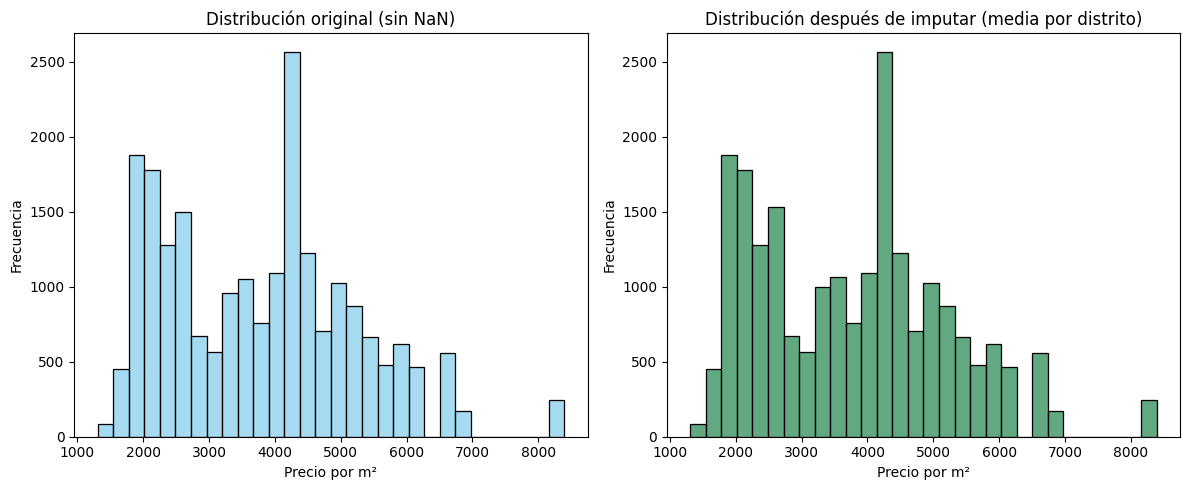

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (1) Mostrar count y porcentaje de NaNs antes de imputar
total = len(df)
n_nan_before = df['price_per_m2'].isna().sum()
pct_nan_before = n_nan_before / total * 100
print(f"Antes de imputar:")
print(f"- NaNs: {n_nan_before} / {total}")
print(f"- Porcentaje: {pct_nan_before:.2f}%\n")

# (2) Crear copia antes de imputar para graficar
df_before = df.copy()

# (3) Calcular la media de cada distrito
district_means = df.groupby('district_id')['price_per_m2'].mean()

# (4) Imputar NaNs con la media del distrito
df['price_per_m2'] = df.apply(
    lambda row: district_means[row['district_id']] if pd.isna(row['price_per_m2']) else row['price_per_m2'],
    axis=1
)

# (5) Mostrar count y porcentaje de NaNs después de imputar
n_nan_after = df['price_per_m2'].isna().sum()
pct_nan_after = n_nan_after / total * 100
print(f"Después de imputar:")
print(f"- NaNs: {n_nan_after} / {total}")
print(f"- Porcentaje: {pct_nan_after:.2f}%\n")

# (6) Graficar la distribución antes y después
plt.figure(figsize=(12, 5))

# Antes de imputar
plt.subplot(1, 2, 1)
sns.histplot(df_before['price_per_m2'].dropna(), bins=30, color='skyblue')
plt.title("Distribución original (sin NaN)")
plt.xlabel("Precio por m²")
plt.ylabel("Frecuencia")

# Después de imputar
plt.subplot(1, 2, 2)
sns.histplot(df['price_per_m2'], bins=30, color='seagreen')
plt.title("Distribución después de imputar (media por distrito)")
plt.xlabel("Precio por m²")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


In [398]:
# Lista de columnas a eliminar
cols_to_drop = [
    'neighborhood_id',
    'neighborhood_num',
    'energy_certificate_num',
    'energy_certificate_knn',
    'energy_certificate_proporcional',
    'energy_certificate_proporcional_num',
    'is_new_development',
    'n_bathrooms',
    'buy_price_by_area',
    'district_name',
    'neighborhood_name',
    'is_new_development_num',
    'has_lift_num',


    # Añade aquí cualquier otra que no quieras usar
]

# Eliminar columnas si existen en el DataFrame
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Mostrar columnas restantes
print("Columnas restantes:")
print(df.columns.tolist())


Columnas restantes:
['street_name', 'floor', 'house_type_id', 'sq_mt_built', 'sq_mt_useful', 'n_rooms', 'built_year', 'is_exterior', 'has_terrace', 'has_balcony', 'is_renewal_needed', 'has_garden', 'has_lift', 'has_ac', 'has_pool', 'has_central_heating', 'has_individual_heating', 'has_parking', 'has_private_parking', 'has_public_parking', 'is_parking_included_in_price', 'is_orientation_north', 'is_orientation_east', 'is_orientation_south', 'is_orientation_west', 'buy_price', 'house_type_Casa', 'house_type_Dúplex', 'house_type_Piso', 'house_type_Ático', 'heating_type_central', 'heating_type_individual', 'heating_type_unknown', 'orientation', 'price_category', 'price_per_m2', 'district_id', 'energy_certificate']


In [399]:
# --- One Hot Encoding de 'district_id' y 'energy_certificate' ---
df = pd.get_dummies(df, columns=['district_id', 'energy_certificate'], prefix=['is_district_', 'is_ernegy_certificate_'], dtype='uint8')

# Mostrar primeras columnas resultantes
df.head()


,street_name,floor,house_type_id,sq_mt_built,sq_mt_useful,n_rooms,built_year,is_exterior,has_terrace,has_balcony,...,is_district__19,is_district__20,is_district__21,is_ernegy_certificate__A,is_ernegy_certificate__B,is_ernegy_certificate__C,is_ernegy_certificate__D,is_ernegy_certificate__E,is_ernegy_certificate__F,is_ernegy_certificate__G
0,Calle de Godella,3.0,HouseType 1: Pisos,-0.617536,-0.508454,-0.665855,1960,1,2,2,...,0,0,1,0,0,0,1,0,0,0
1,Calle de la del Manojo de Rosas,4.0,HouseType 1: Pisos,-0.572705,-0.166557,-0.003806,1958,1,1,2,...,0,0,1,0,0,0,0,0,1,0
2,Calle del Talco,1.0,HouseType 1: Pisos,-0.393382,-0.616422,-0.665855,1972,1,2,2,...,0,0,1,0,0,0,0,1,0,0
3,Calle Pedro Jiménez,0.0,HouseType 1: Pisos,-0.617536,-0.166557,-0.665855,1955,1,2,2,...,0,0,1,0,0,0,0,1,0,0
4,Carretera de Villaverde a Vallecas,4.0,HouseType 1: Pisos,-0.288777,0.031384,-0.665855,2003,1,2,2,...,0,0,1,0,0,0,0,1,0,0


### Delete old columns

In [400]:
for col in HEATING_COLUMNS:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

if 'house_type_id' in df.columns:
    df.drop('house_type_id', axis=1, inplace=True)

# Drop orientation columns since we've created a combined 'orientation' column
for col in ORIENTATION_COLUMNS:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Drop redundant parking columns if they exist
if 'has_private_parking' in df.columns:
    df.drop('has_private_parking', axis=1, inplace=True)
if 'has_public_parking' in df.columns:
    df.drop('has_public_parking', axis=1, inplace=True)
if 'is_parking_included_in_price' in df.columns:
    df.drop('is_parking_included_in_price', axis=1, inplace=True)

if 'street_name' in df.columns:
    df.drop('street_name', axis=1, inplace=True)

if 'buy_price' in df.columns:
    df.drop('buy_price', axis=1, inplace=True)

## Final results

#### Final analysis

In [401]:
df.head()
nulls = df.isnull().mean() * 100
print("Porcentage de nulos por columna:")
display(nulls.sort_values(ascending=False))

Porcentage de nulos por columna:


floor                       0.0
is_district__15             0.0
is_district__5              0.0
is_district__6              0.0
is_district__7              0.0
is_district__8              0.0
is_district__9              0.0
is_district__10             0.0
is_district__11             0.0
is_district__12             0.0
is_district__13             0.0
is_district__14             0.0
is_district__17             0.0
is_district__3              0.0
is_district__18             0.0
is_district__19             0.0
is_district__20             0.0
is_district__21             0.0
is_ernegy_certificate__A    0.0
is_ernegy_certificate__B    0.0
is_ernegy_certificate__C    0.0
is_ernegy_certificate__D    0.0
is_ernegy_certificate__E    0.0
is_ernegy_certificate__F    0.0
is_district__4              0.0
is_district__2              0.0
sq_mt_built                 0.0
has_pool                    0.0
sq_mt_useful                0.0
n_rooms                     0.0
built_year                  0.0
is_exter

#### Save preprocessed data

In [402]:
# Save preprocessed data
df.to_csv('preprocessed.csv', index=False)